In [ ]:
!pip install -U earthengine-api
!pip install geemap
import ee
import geemap.core as geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.0 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow
!nvidia-smi
import tensorflow as tf

# Создаем стратегию для всех доступных GP)
# Разделяем 1 GPU на 4 логических устройства
physical_gpus = tf.config.list_physical_devices('GPU')
if physical_gpus:
    try:
        tf.config.set_logical_device_configuration(
            physical_gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=5120) for _ in range(4)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(physical_gpus)} физический GPU → {len(logical_gpus)} логических GPU")
    except RuntimeError as e:
        print("Ошибка:", e)
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

Mon May  5 18:11:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   68C    P8             18W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize(project='ee-matyash-01')

In [ ]:
ee.Initialize(project='ee-matyash-01')
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(
    '2020-12-01', '2020-12-31'
)


# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )


dataset = dataset.map(apply_scale_factors)

visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

m = geemap.Map()
m.set_center(45.2579, 46.3275, 10)
m.add_layer(dataset, visualization, 'True Color (432)')
m
ndwi = dataset.normalizedDifference(['B3', 'B5'])
ndwi_viz = {'min': 0.5, 'max': 1, 'palette': ['00FFFF', '0000FF']}

# Define a map centered on San Francisco Bay.
map_ndwi = geemap.Map(center=[37.5010, -122.1899], zoom=10)

# Add the image layer to the map and display it.
map_ndwi.add_layer(ndwi, ndwi_viz, 'NDWI')
display(map_ndwi)

In [ ]:
import ee
import geemap
import time
import sys


# Параметры региона
roi = ee.Geometry.Polygon([
    [93.00, 56.00],  # Юго-запад
    [93.00, 56.20],  # Северо-запад
    [93.20, 56.20],  # Северо-восток
    [93.20, 56.00],  # Юго-восток
    [93.00, 56.00]   # Замыкаем полигон
])
date_start = '2015-06-01'
date_end = '2015-09-30'
cloud_cover_max = 40  # Максимальная облачность в %

def get_landsat_image(roi, date_start, date_end, cloud_cover_max):
    """Получает наименее облачное изображение Landsat 8"""
    collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                 .filterBounds(roi)
                 .filterDate(date_start, date_end)
                 .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover_max)))

    # Проверяем, есть ли изображения в коллекции
    if collection.size().getInfo() == 0:
        print("Нет подходящих изображений Landsat 8 для указанных параметров.")
        print("Попробуйте:")
        print("- Увеличить диапазон дат")
        print("- Увеличить допустимую облачность")
        print("- Изменить регион интереса")
        return None

    return collection.sort('CLOUD_COVER').first()

# Получаем изображение
image = get_landsat_image(roi, date_start, date_end, cloud_cover_max)

if image is None:
    sys.exit(1)

# Проверяем, какие каналы доступны
print("Доступные каналы:", image.bandNames().getInfo())

# Выбираем нужные каналы (обязательно проверьте, что они существуют)
try:
    image = image.select(['SR_B2', 'SR_B3', 'SR_B5'])  # Blue, Green, RED
except Exception as e:
    print("Ошибка при выборе каналов:", e)
    print("Возможно, указанные каналы отсутствуют в этом изображении")
    sys.exit(1)

# Функция безопасного экспорта
def safe_export(image, description, folder, scale=30, retries=3):
    for attempt in range(retries):
        try:
            task = ee.batch.Export.image.toDrive(
                image=image,
                description=description[:100],  # Ограничение длины описания
                folder=folder,
                scale=scale,
                region=roi,
                maxPixels=1e8,
                fileFormat='GEO_TIFF',
            )
            task.start()
            print(f"Задача экспорта '{description}' запущена (попытка {attempt+1})")

            # Ожидание завершения
            while task.active():
                status = task.status()
                print(f"Статус: {status['state']}, {status.get('progress', '')}")
                time.sleep(10)

            if task.status()['state'] == 'COMPLETED':
                print(f"Экспорт {description} успешно завершен!")
                return True

        except Exception as e:
            print(f"Ошибка при экспорте (попытка {attempt+1}):", str(e))
            time.sleep(30)

    print(f"Не удалось экспортировать {description} после {retries} попыток")
    return False

# Экспорт изображения
if not safe_export(image, 'Landsat8_RGB', 'Landsat_Exports'):
    print("Не удалось экспортировать изображение")
    sys.exit(1)

print("Готово! Проверьте ваш Google Drive.")

EEException: Earth Engine client library not initialized. See http://goo.gle/ee-auth.

Форма загруженных данных: (1, 1195, 2482)


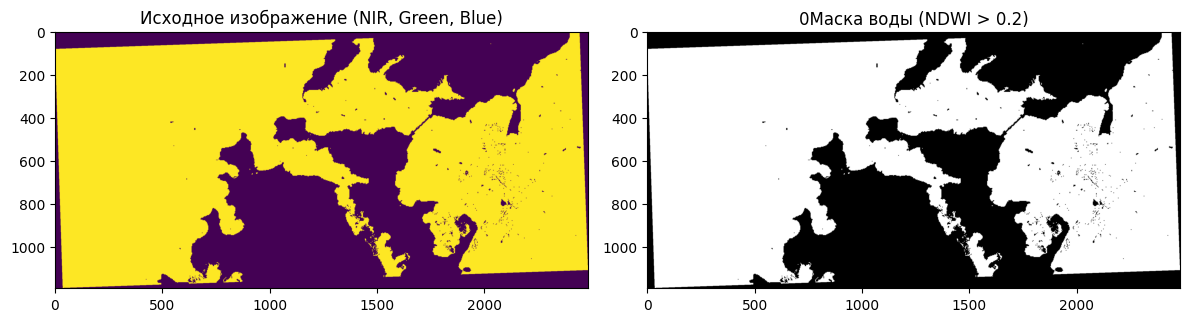

Форма загруженных данных: (1, 1204, 2486)


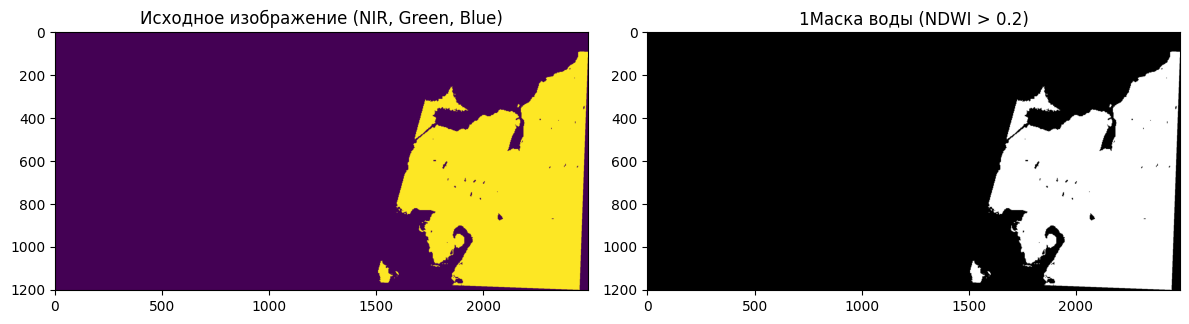

Форма загруженных данных: (1, 1195, 2482)


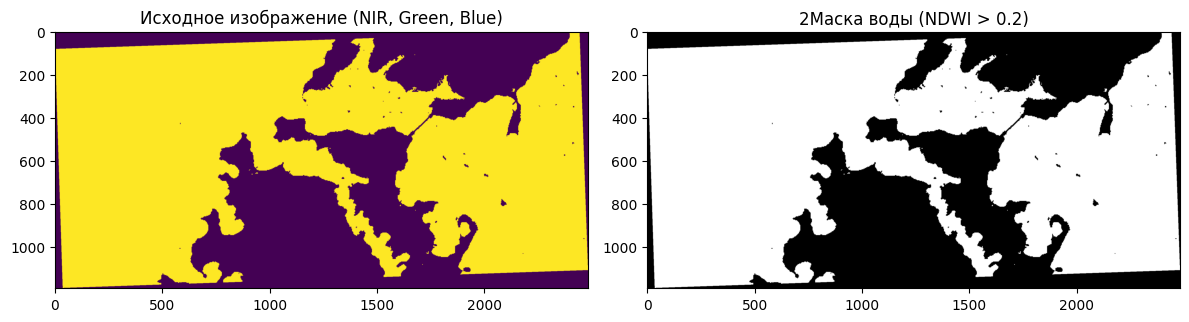

Форма загруженных данных: (1, 1195, 2482)


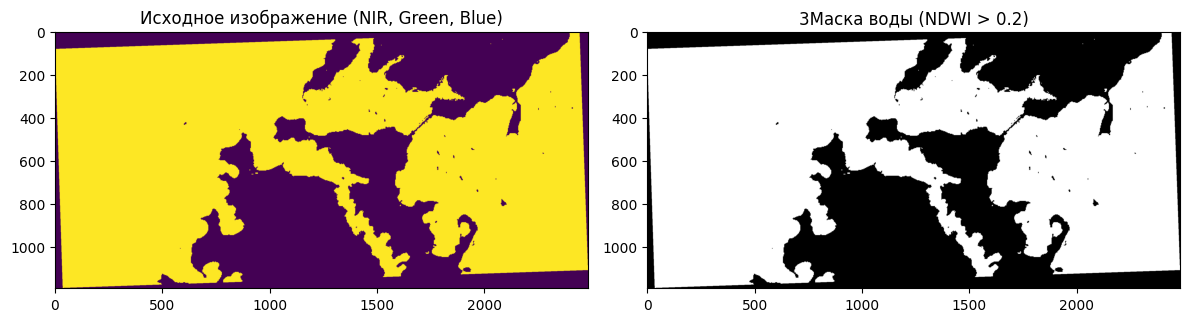

Форма загруженных данных: (1, 1204, 2486)


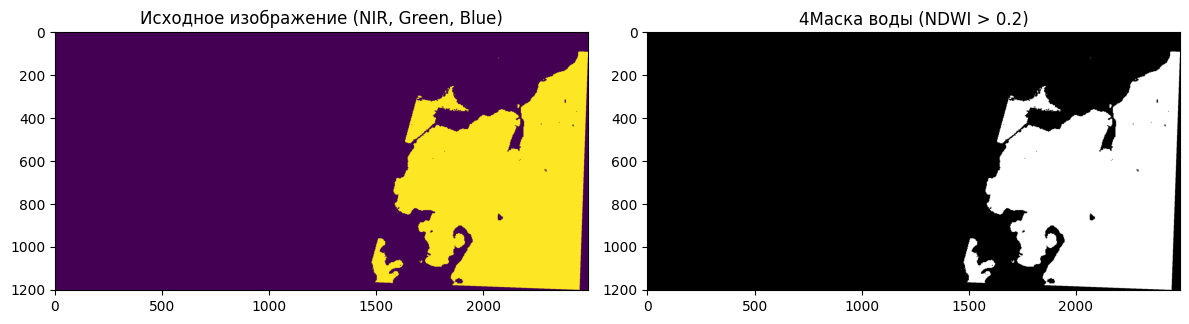

Форма загруженных данных: (1, 1204, 2486)


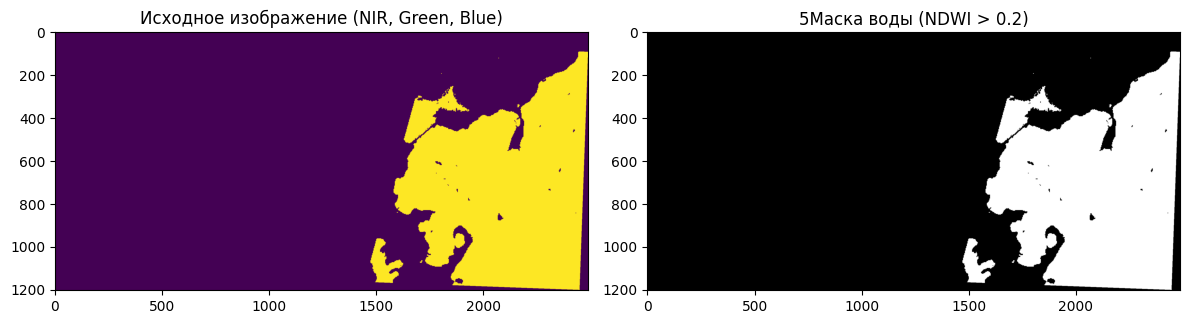

Форма загруженных данных: (1, 1195, 2482)


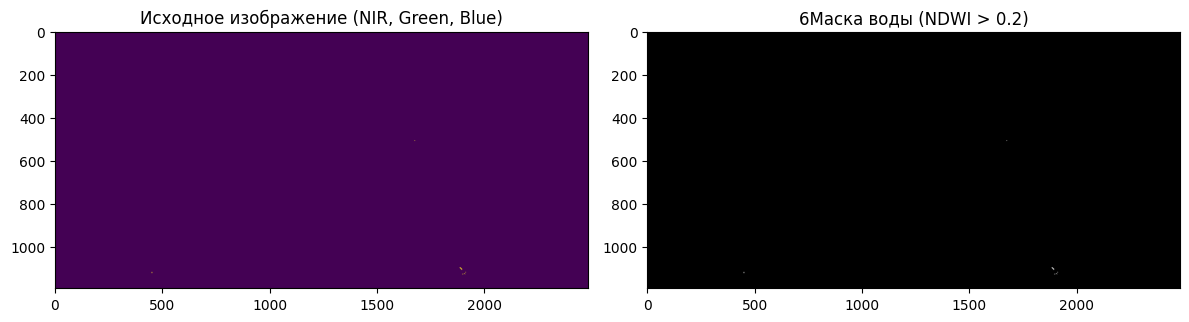

Форма загруженных данных: (1, 1204, 2486)


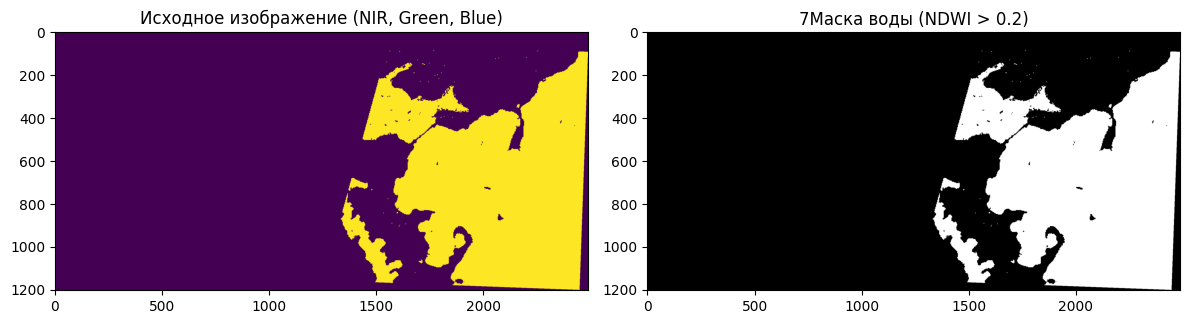

Форма загруженных данных: (1, 1195, 2482)


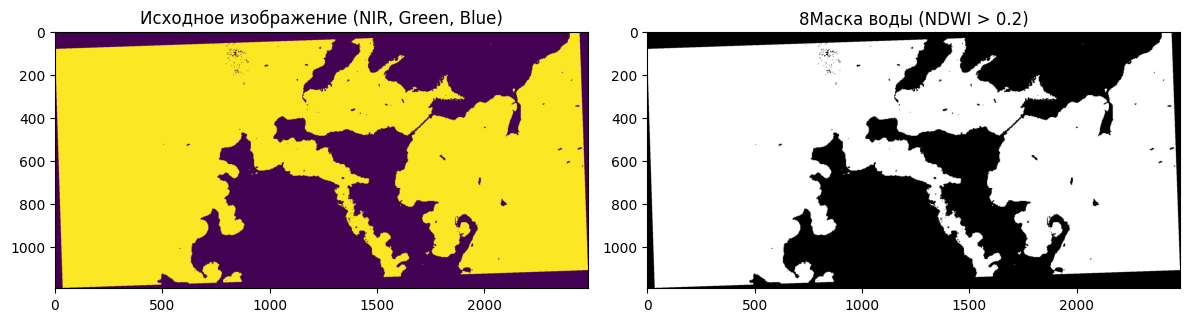

Форма загруженных данных: (1, 1195, 2482)


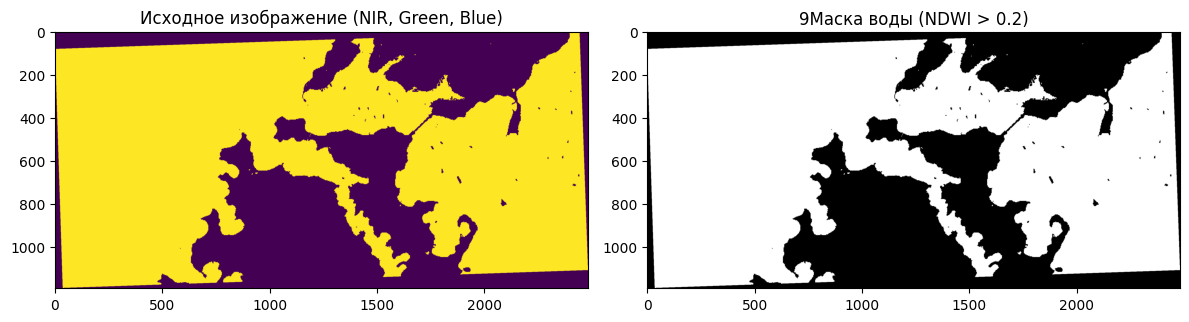

Форма загруженных данных: (1, 1204, 2486)


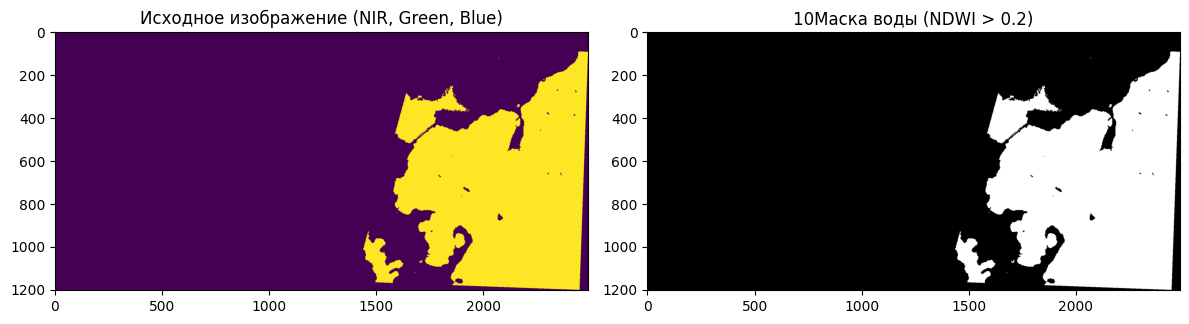

Форма загруженных данных: (1, 1195, 2482)


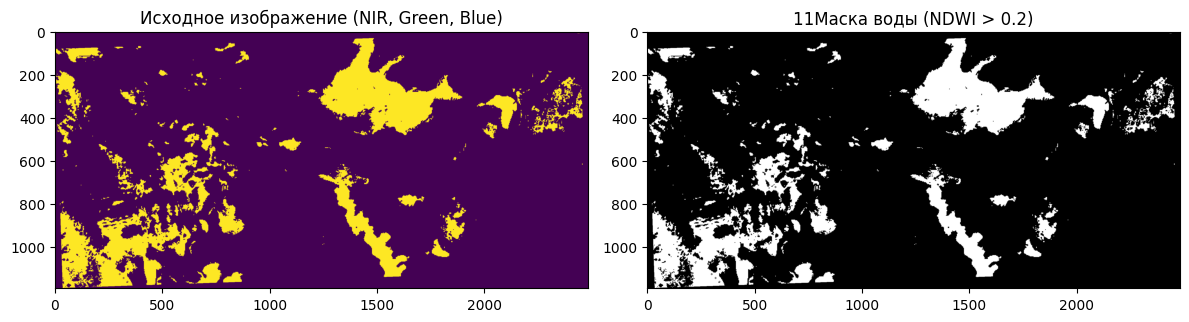

Форма загруженных данных: (1, 1195, 2482)


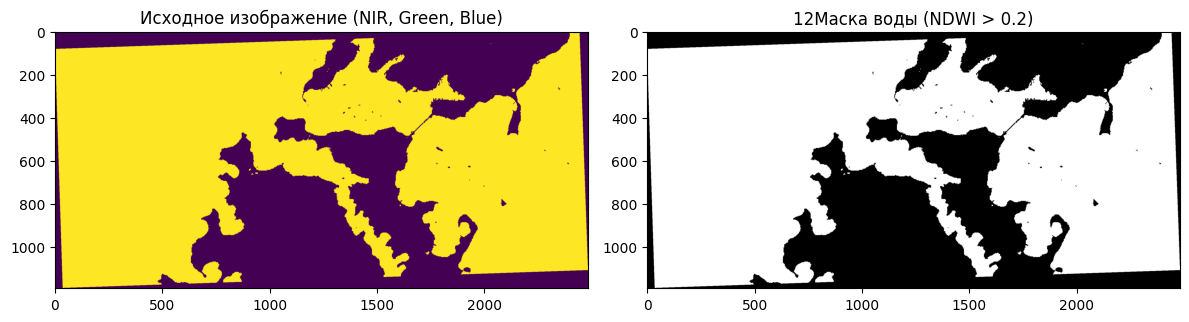

Форма загруженных данных: (1, 1195, 2482)


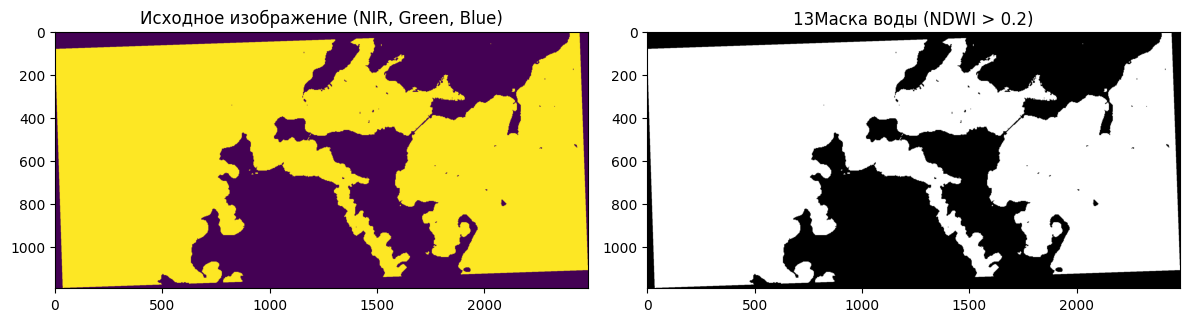

Форма загруженных данных: (1, 1195, 2482)


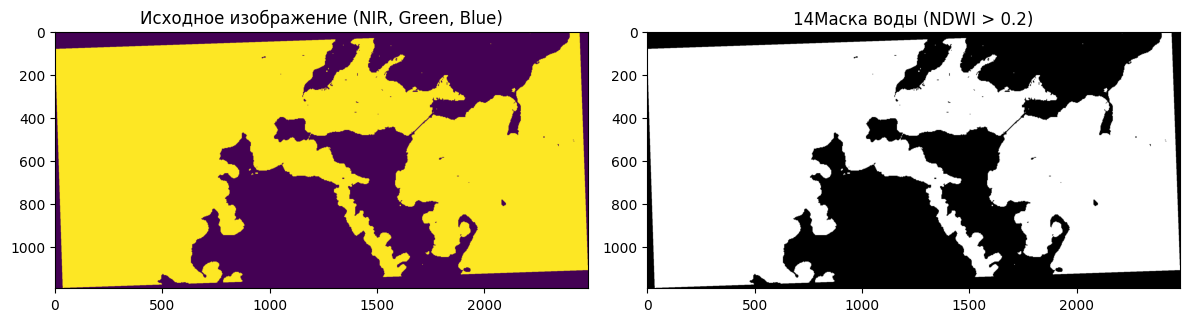

Форма загруженных данных: (1, 1204, 2486)


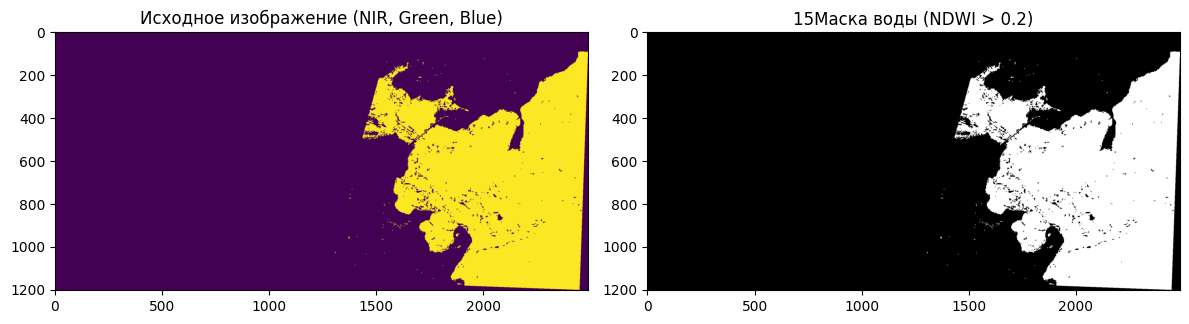

Форма загруженных данных: (1, 1204, 2486)


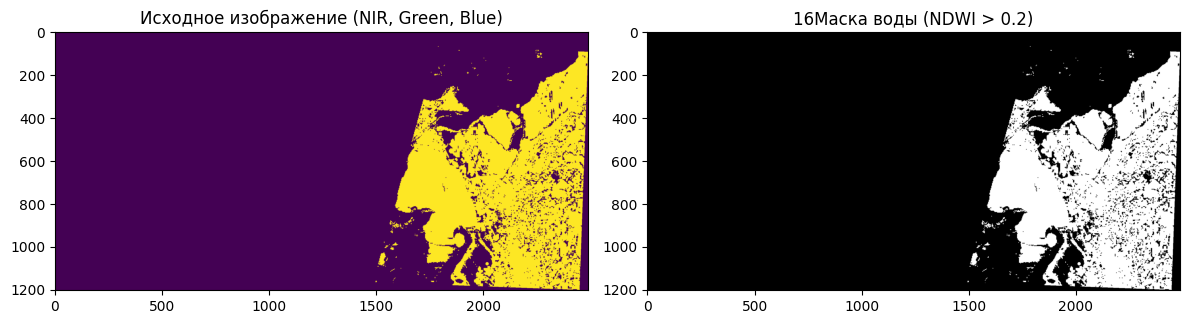

Форма загруженных данных: (1, 1198, 1098)


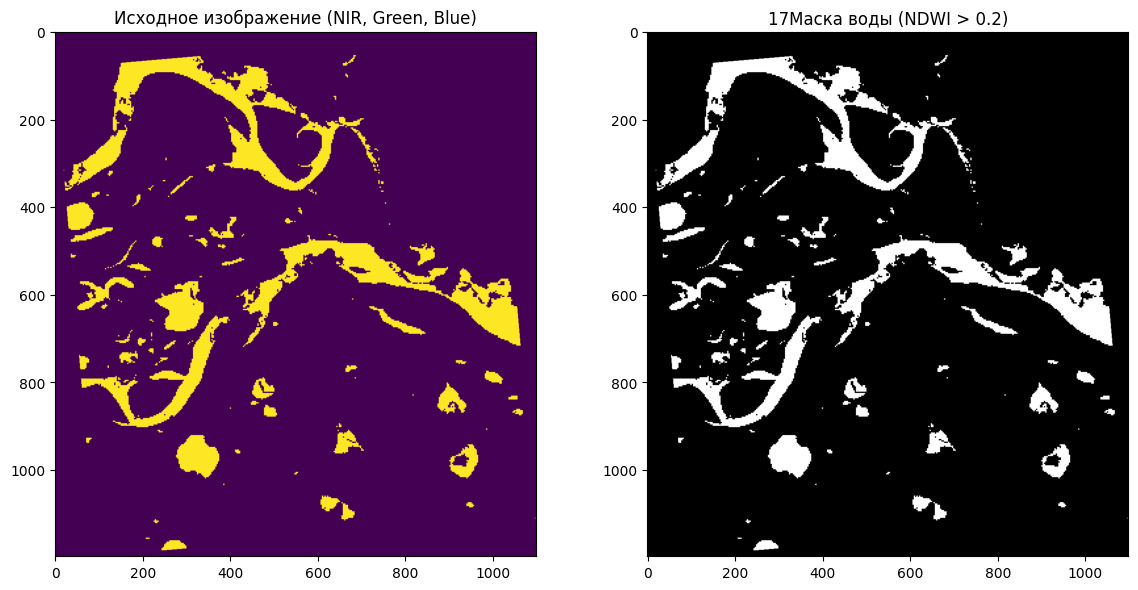

Форма загруженных данных: (1, 1131, 1021)


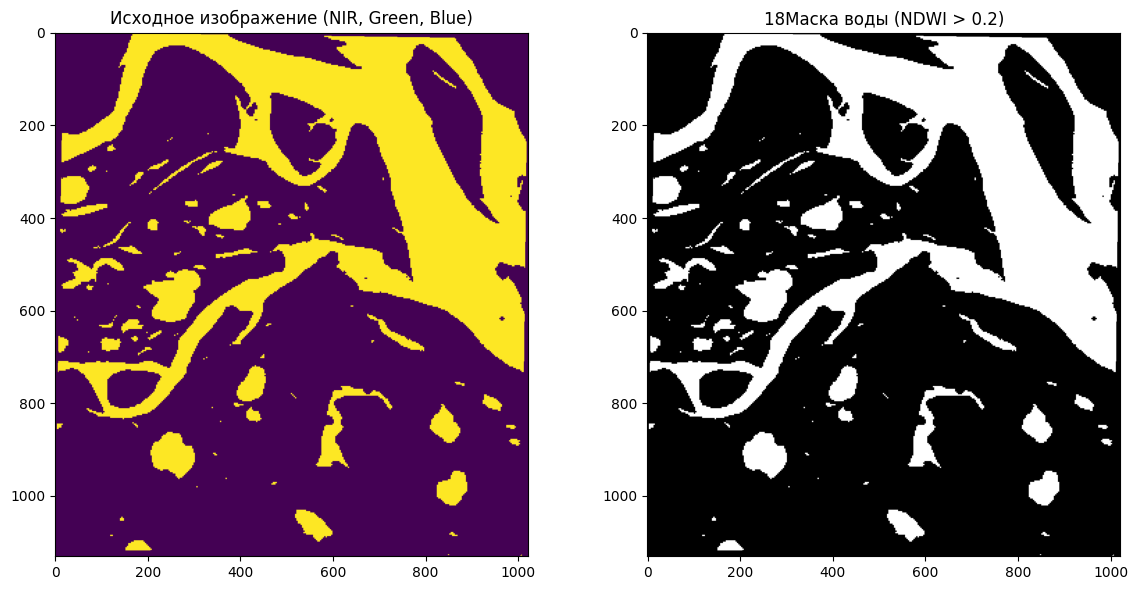

Форма загруженных данных: (1, 1198, 1098)


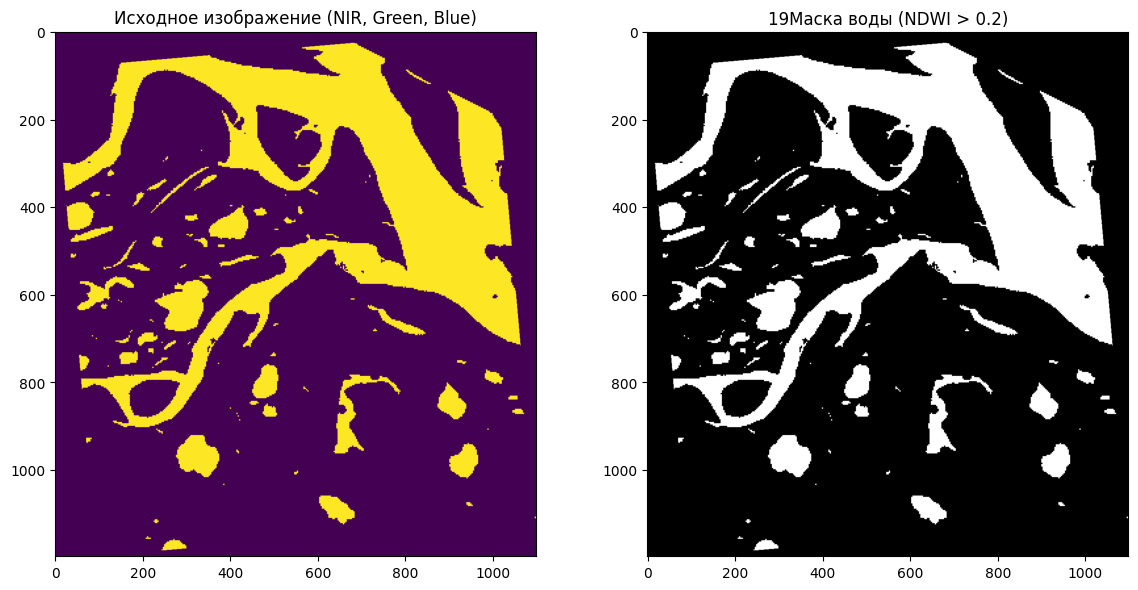

Форма загруженных данных: (1, 1131, 1021)


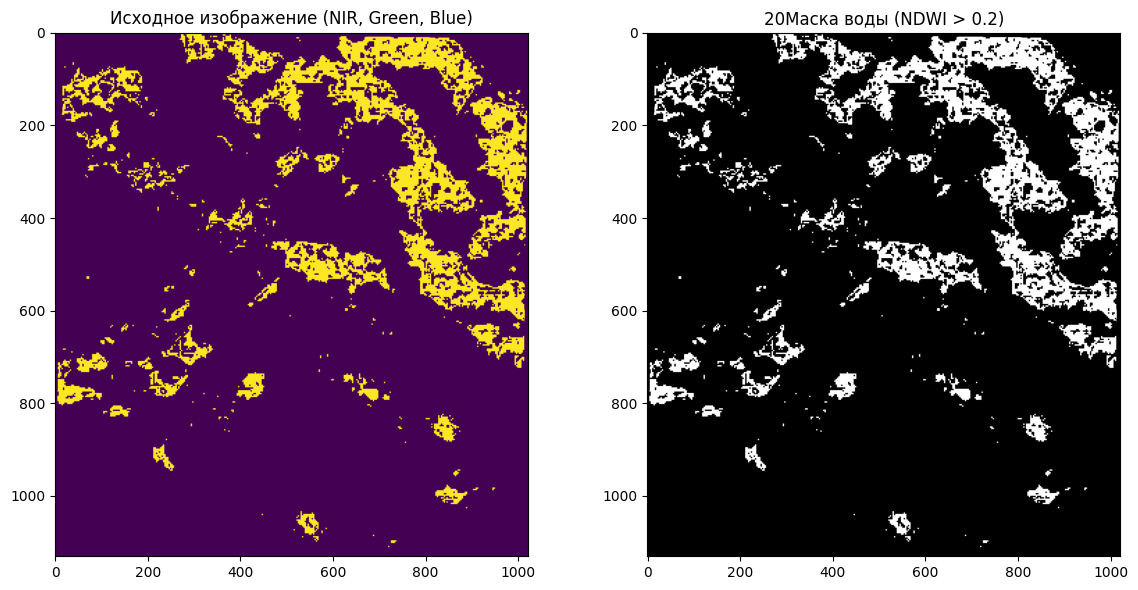

Форма загруженных данных: (1, 1198, 1098)


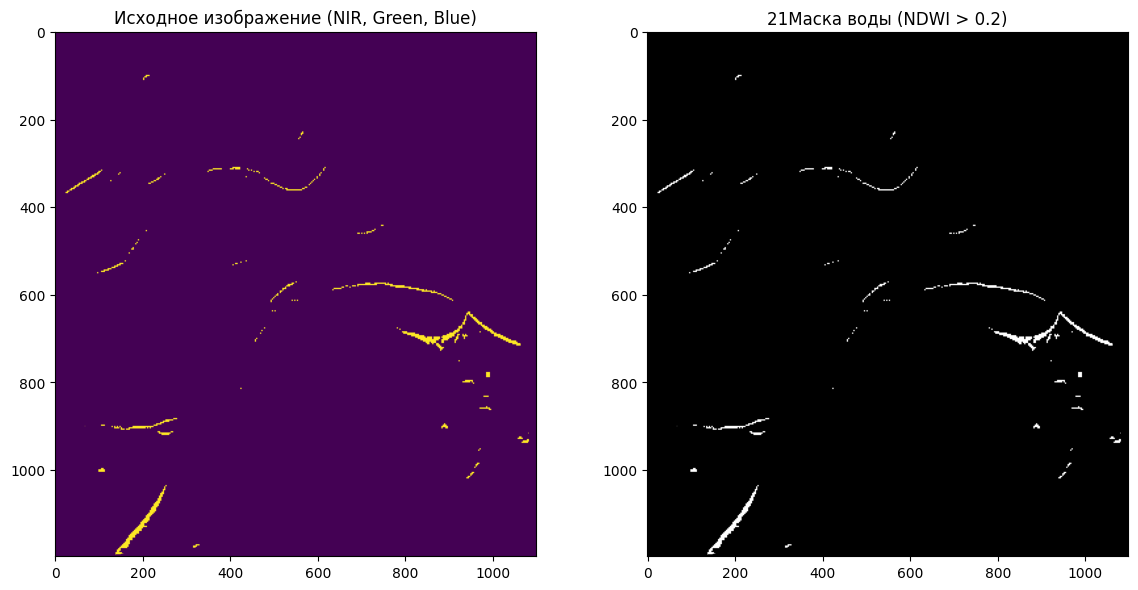

Форма загруженных данных: (1, 1198, 1098)


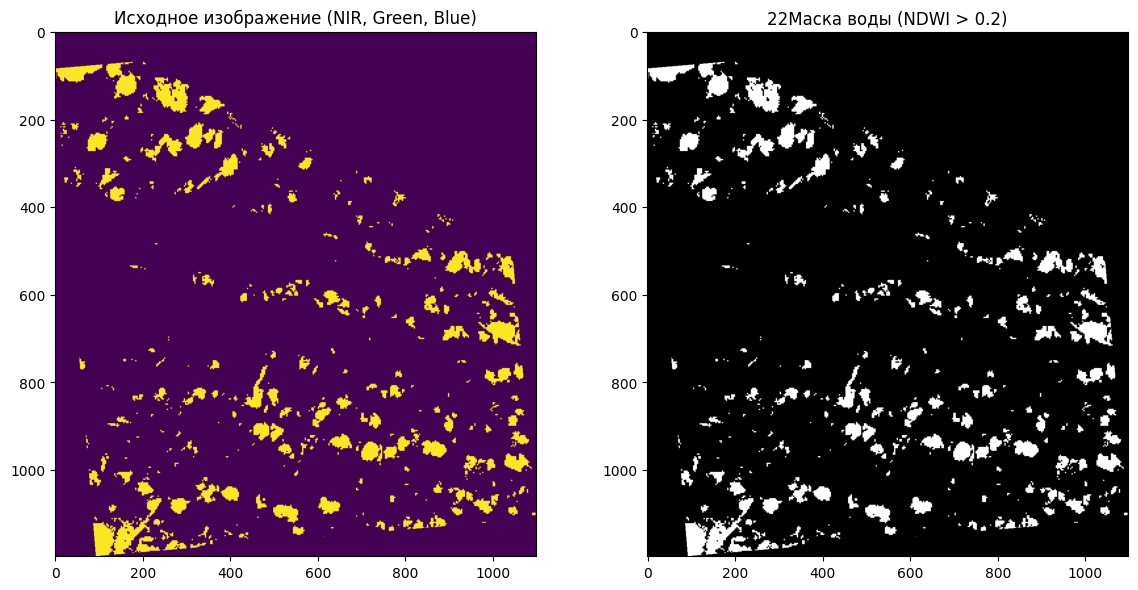

Форма загруженных данных: (1, 1131, 1021)


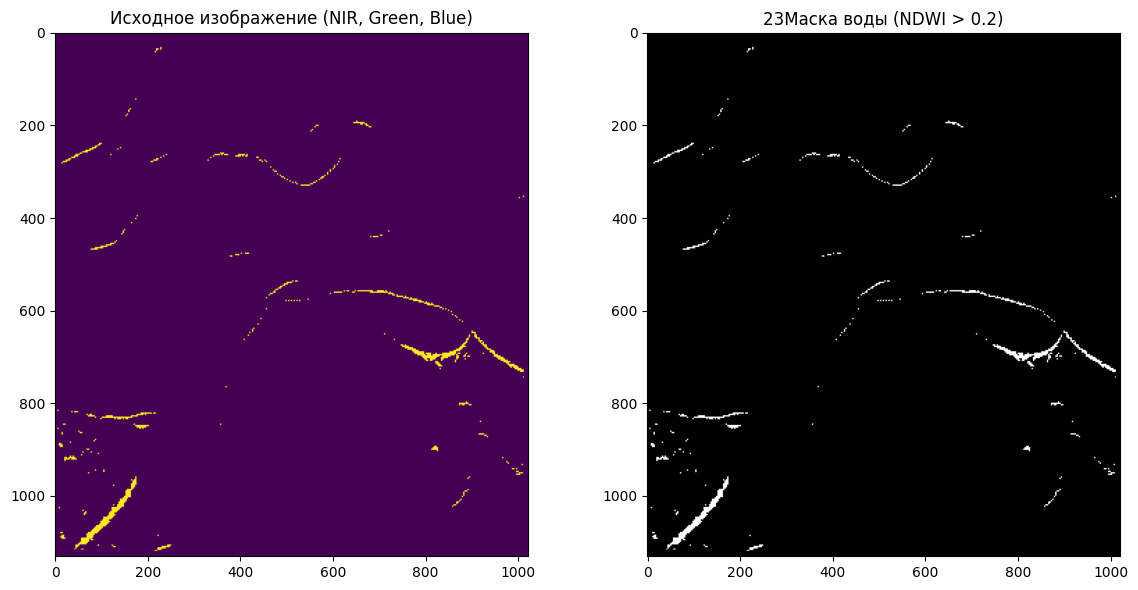

Форма загруженных данных: (1, 1131, 1021)


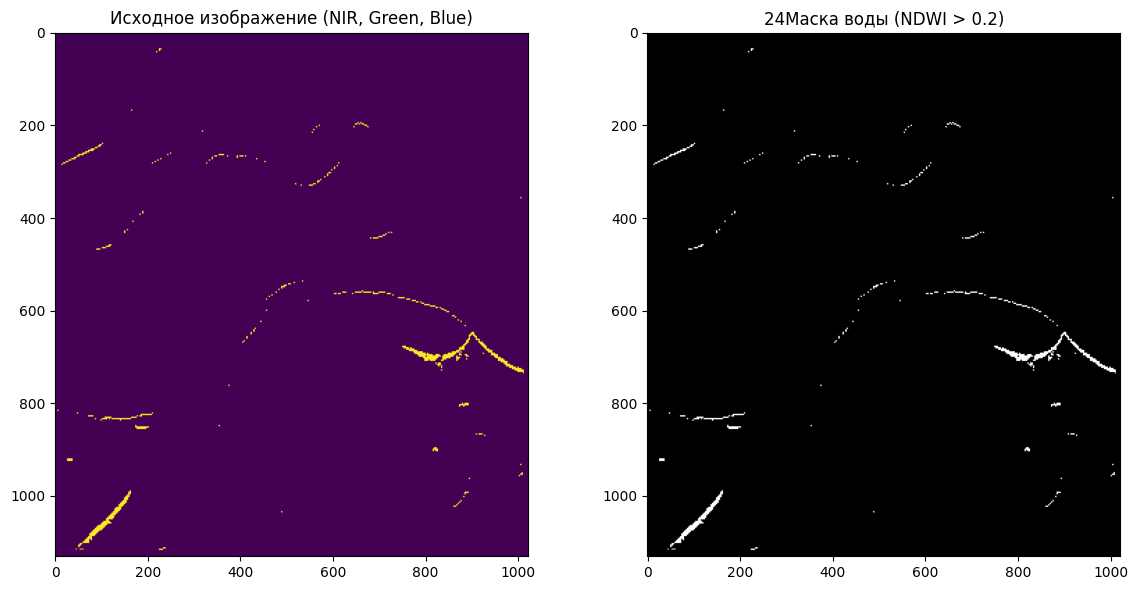

Форма загруженных данных: (1, 1198, 1098)


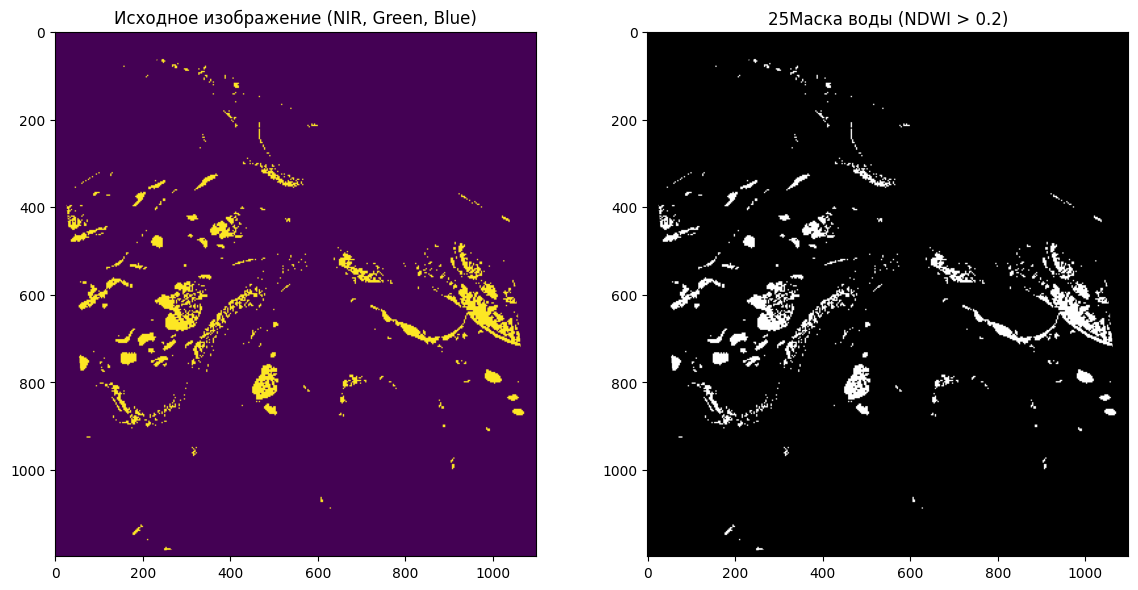

Форма загруженных данных: (1, 1131, 1021)


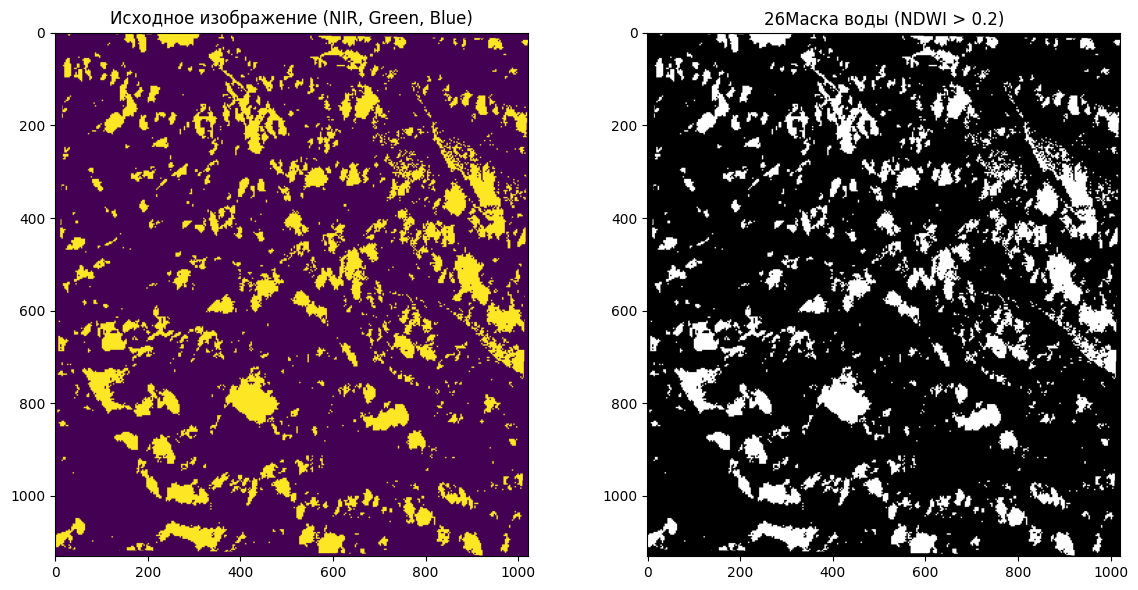

Форма загруженных данных: (1, 1131, 1021)


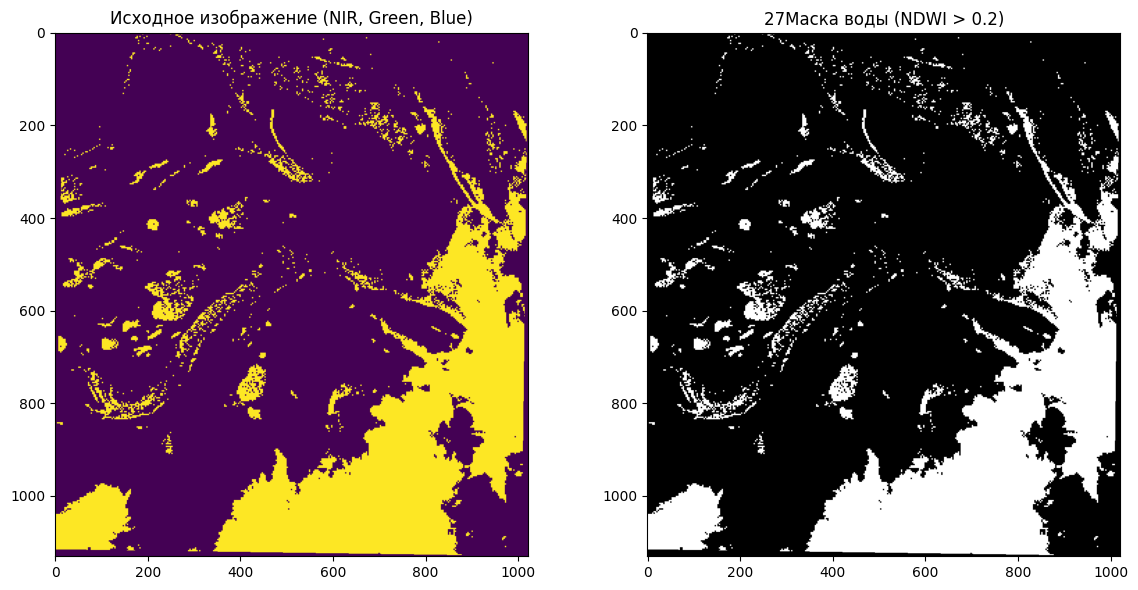

Форма загруженных данных: (1, 1198, 1098)


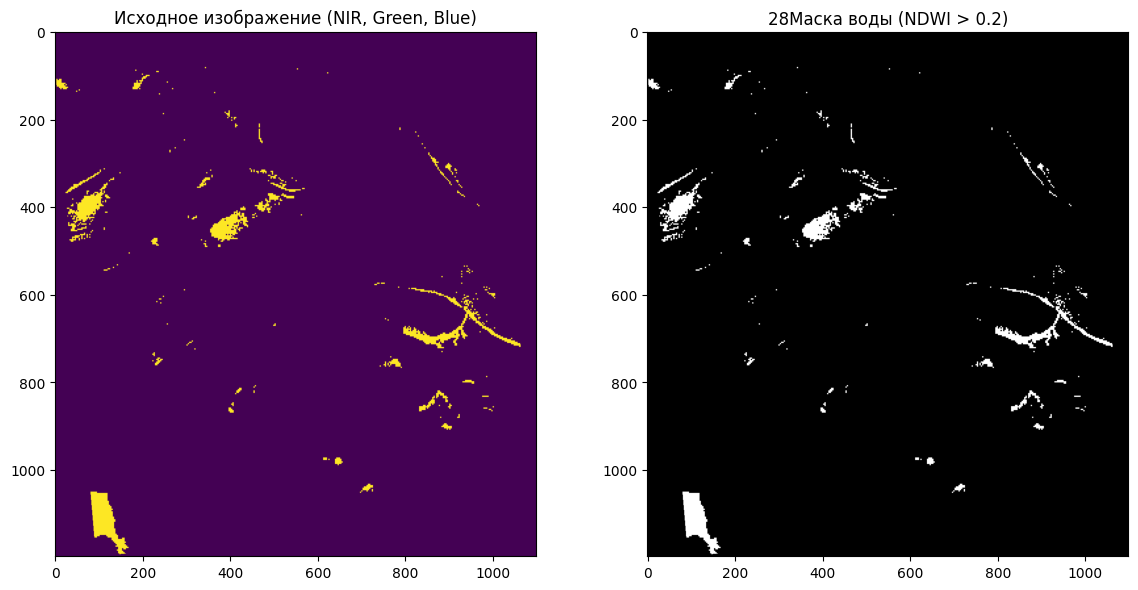

Форма загруженных данных: (1, 1131, 1021)


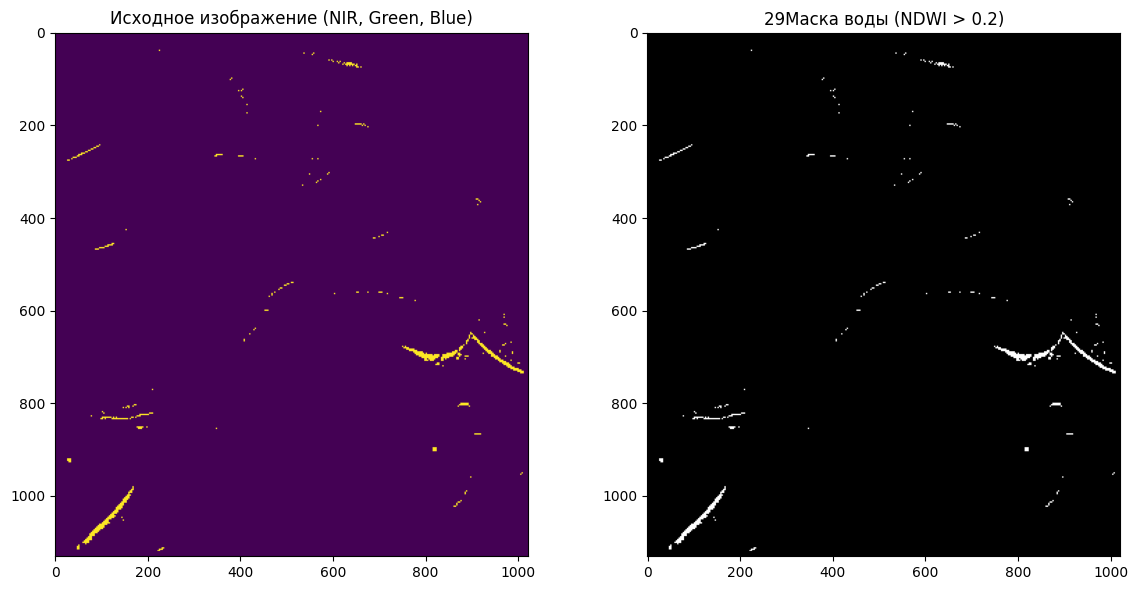

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# 1. Загрузка данных
for i in range(30):
  with rasterio.open(os.path.join("water_dataset_final", f'mask_{i}.tif')) as src:
      bands = src.read()  # Форма: (каналы, высота, ширина)
      meta = src.meta

  # 2. Проверка формы данных
  print("Форма загруженных данных:", bands.shape)  # Должно быть (каналы, H, W)



  # 4. Создание RGB изображения (правильный порядок каналов)
  rgb_image = np.dstack([bands[0]])  # Формируем (H, W, 3)
  # 6. Визуализация с правильными формами данных
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  # Визуализация RGB
  ax1.imshow(rgb_image)  # Нормализация
  ax1.set_title('Исходное изображение (NIR, Green, Blue)')

  # Визуализация маски воды
  ax2.imshow(rgb_image, cmap='gray')
  ax2.set_title(f'{i}Маска воды (NDWI > 0.2)')

  plt.tight_layout()
  plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 60.3 MB/s eta 0:00:00
=== Начало создания датасета ===

=== Подготовка финального датасета ===
Найдено 82 пар изображение-маска


100%|██████████| 82/82 [00:05<00:00, 14.40it/s]



Итоговые размеры:
Train: (1374, 256, 256, 3)
Val: (172, 256, 256, 3)
Test: (172, 256, 256, 3)


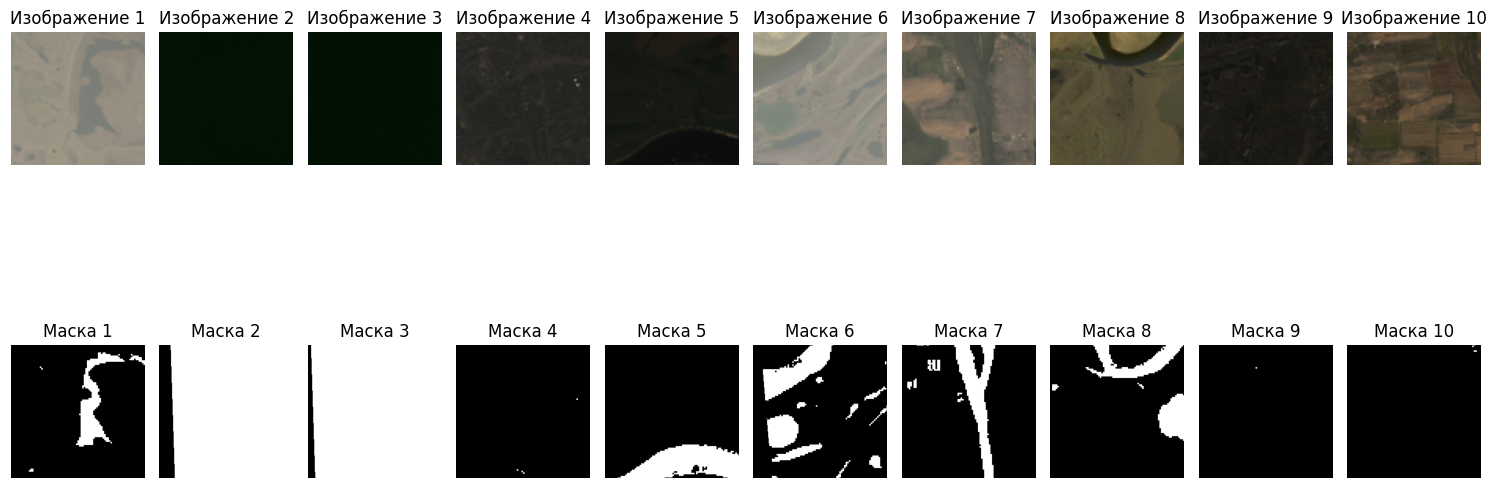

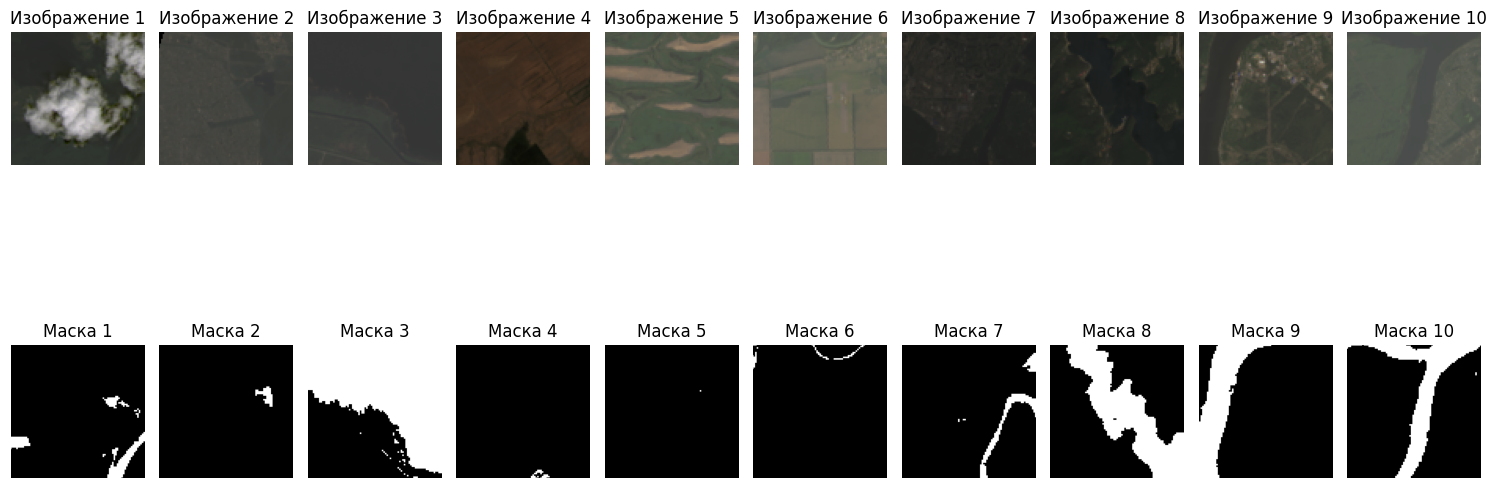

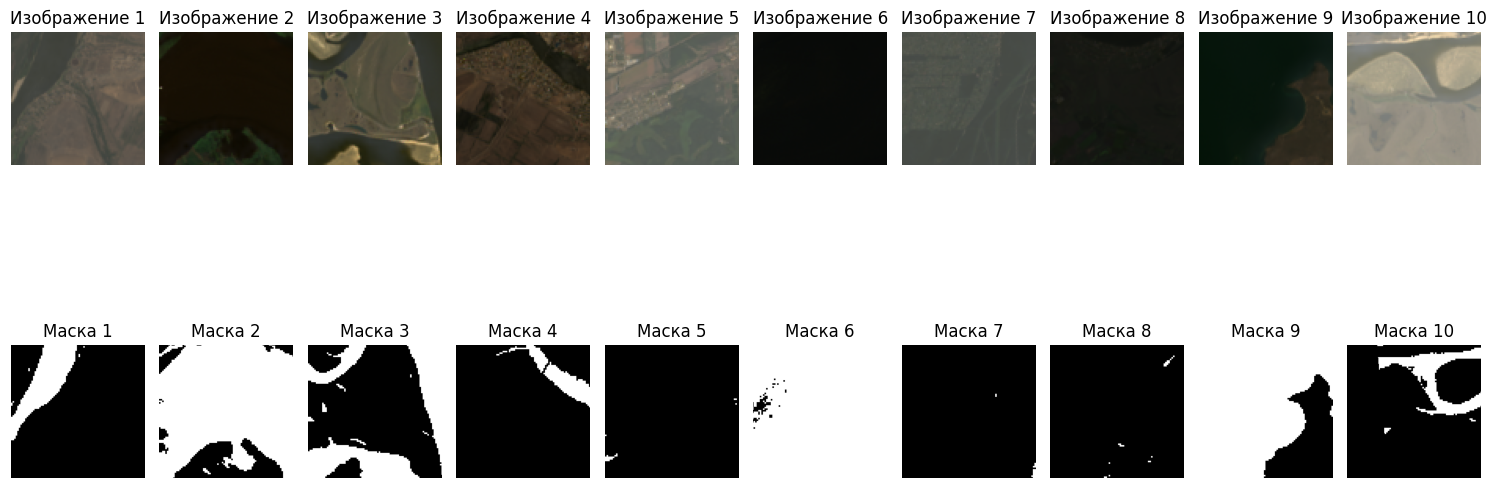


=== Готово! ===


In [ ]:
!pip install rasterio
import ee
import geemap
import numpy as np
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split



# Настройки
OUTPUT_DIR = 'water_dataset_final'
os.makedirs(OUTPUT_DIR, exist_ok=True)
TILE_SIZE = 256  # Размер тайлов
SCALE = 10  # Разрешение Landsat
NUM_IMAGES = 81  # Количество изображений
MAX_CLOUD_COVER = 20  # Максимальная облачность (%)

# Регионы для сбора данных
REGIONS = [
    # ee.Geometry.Rectangle([37.3, 55.7, 37.6, 55.8])  # Москва-река
    # ee.Geometry.Rectangle([30.9, 59.9, 31.2, 60.0]),  # Нева (Санкт-Петербург)
    # ee.Geometry.Rectangle([47.8, 46.2, 48.1, 46.3]),  # Дельта Волги
    # ee.Geometry.Rectangle([93.1, 56.1, 93.4, 56.2]),  # Енисей (Красноярск)
    # ee.Geometry.Rectangle([104.0, 52.0, 105.0, 53.0]),  # Озеро Байкал
    # ee.Geometry.Rectangle([87.0, 71.5, 89.0, 72.5]),  # Дельта Енисея
    ee.Geometry.Rectangle([131.7, 43.0, 132.0, 43.1]),  # Амурский залив (Владивосток)
    # ee.Geometry.Rectangle([69.1, 66.7, 69.4, 66.8]),  # Обская губа (Ямал)
    # ee.Geometry.Rectangle([128.0, 72.5, 128.3, 72.6]),  # Дельта Лены
    # ee.Geometry.Rectangle([40.4, 45.35, 40.6, 45.45])  # Кубань (Краснодар)
]

# Временные периоды
DATE_RANGES = [
    ('2018-06-01', '2018-08-31'),  # Лето 2018
    ('2019-06-01', '2019-08-31'),  # Лето 2019
    ('2020-06-01', '2020-08-31'),  # Лето 2020
    ('2018-09-01', '2018-10-31'),  # Осень 2018
    ('2019-09-01', '2019-10-31'),  # Осень 2019
    ('2018-04-01', '2018-05-31'),  # Весна 2018
    ('2019-04-01', '2019-05-31'),  # Весна 2019
    ('2020-04-01', '2020-05-31'),  # Весна 2020
    ('2018-03-01', '2018-03-31'),  # Зима 2018
    ('2015-02-01', '2015-02-28')   # Зима 2019
]

def calculate_ndwi(img):
    """Расчет NDWI с масштабированием значений"""
    green = img.select('SR_B3').multiply(0.0000275).add(-0.2)
    nir = img.select('SR_B5').multiply(0.0000275).add(-0.2)
    return green.subtract(nir).divide(green.add(nir).add(1e-9)).rename('NDWI')

def export_image_pair(image, roi, index):
    """Экспорт пары RGB и маски воды"""
    try:
        # Создание RGB и маски
        rgb = image.select(['SR_B4', 'SR_B3', 'SR_B2'])
        ndwi = calculate_ndwi(image)
        water_mask = ndwi.gt(0.085).selfMask().uint8()

        # Проверка наличия воды
        stats = water_mask.reduceRegion(
            ee.Reducer.mean(),
            geometry=roi,
            scale=SCALE
        ).getInfo()

        if not stats or stats.get('NDWI', 0) < 0.01:
            return False

        # Экспорт RGB
        rgb_path = os.path.join(OUTPUT_DIR, f'rgb_{index}.tif')
        geemap.ee_export_image(
            rgb.clip(roi),
            filename=rgb_path,
            scale=SCALE,
            region=roi
        )

        # Экспорт маски
        mask_path = os.path.join(OUTPUT_DIR, f'mask_{index}.tif')
        geemap.ee_export_image(
            water_mask.clip(roi),
            filename=mask_path,
            scale=SCALE,
            region=roi
        )

        return True

    except Exception as e:
        print(f"Ошибка экспорта {index}: {str(e)}")
        return False

def create_dataset():
    """Создание набора данных"""
    processed_count = 0

    for region in REGIONS:
        for start_date, end_date in DATE_RANGES:
            if processed_count >= NUM_IMAGES:
                break

            print(f"Обработка региона {REGIONS.index(region)+1}, период {start_date}-{end_date}")

            collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterBounds(region) \
                .filterDate(start_date, end_date) \
                .filter(ee.Filter.lt('CLOUD_COVER', MAX_CLOUD_COVER)) \
                .sort('CLOUD_COVER')

            images = collection.toList(10)

            for i in tqdm(range(images.size().getInfo())):
                if processed_count >= NUM_IMAGES:
                    break

                if export_image_pair(ee.Image(images.get(i)), region, processed_count):
                    processed_count += 1
                    print(f"Обработано: {processed_count}/{NUM_IMAGES}")

def prepare_dataset():
    """Подготовка финального датасета с проверкой соответствия масок"""
    # Получаем список файлов и проверяем соответствие
    file_pairs = []
    for f in os.listdir(OUTPUT_DIR):
        if f.startswith('rgb_'):
            mask_file = f.replace('rgb_', 'mask_')
            if os.path.exists(os.path.join(OUTPUT_DIR, mask_file)):
                file_pairs.append((f, mask_file))

    print(f"Найдено {len(file_pairs)} пар изображение-маска")

    all_images = []
    all_masks = []
    skipped = 0

    for rgb_file, mask_file in tqdm(file_pairs, total=len(file_pairs)):
        try:
            # Загрузка с явной проверкой соответствия
            rgb_path = os.path.join(OUTPUT_DIR, rgb_file)
            mask_path = os.path.join(OUTPUT_DIR, mask_file)

            # Проверка что имена действительно соответствуют
            if not rgb_file.replace('rgb_', '') == mask_file.replace('mask_', ''):
                print(f"Несоответствие имен: {rgb_file} vs {mask_file}")
                skipped += 1
                continue

            with rasterio.open(rgb_path) as src_rgb, rasterio.open(mask_path) as src_mask:
                # Проверка одинаковых размеров
                if src_rgb.shape != src_mask.shape:
                    print(f"Размеры не совпадают: {rgb_file} {src_rgb.shape} vs {mask_file} {src_mask.shape}")
                    skipped += 1
                    continue

                img = src_rgb.read()
                mask = src_mask.read()

                # Дополнительная проверка маски
                if np.all(mask == 0):
                    skipped += 1
                    continue

            # Нормализация и подготовка
            img = np.transpose(img, (1, 2, 0))
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            mask = np.transpose(mask, (1, 2, 0))

            # Разбиение на тайлы с сохранением соответствия
            h, w = img.shape[0], img.shape[1]
            for i in range(0, h - TILE_SIZE + 1, TILE_SIZE):
                for j in range(0, w - TILE_SIZE + 1, TILE_SIZE):
                    img_tile = img[i:i+TILE_SIZE, j:j+TILE_SIZE]
                    mask_tile = mask[i:i+TILE_SIZE, j:j+TILE_SIZE]

                    # Сохраняем только тайлы с водой
                    if np.any(mask_tile > 0):
                        all_images.append(img_tile)
                        all_masks.append(mask_tile)

        except Exception as e:
            print(f"Ошибка обработки {rgb_file}: {str(e)}")
            skipped += 1

    # Проверка финального соответствия
    assert len(all_images) == len(all_masks), "Несоответствие количества изображений и масок"

    # Преобразуем в numpy массивы
    X = np.stack(all_images)
    y = np.stack(all_masks)

    # Проверка shapes
    assert X.shape[0] == y.shape[0], "Несоответствие количества образцов"
    assert X.shape[1:3] == y.shape[1:3], "Несоответствие размеров изображений"


    # Разделение на наборы
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=0.2,
        random_state=36,  # Фиксируем random_state для воспроизводимости
        shuffle=True      # Перемешиваем данные перед разделением
    )

    # 2. Затем временную выборку делим на validation и test (50% val, 50% test от temp)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=23,
        shuffle=True
    )


    # Сохранение
    np.savez_compressed(os.path.join(OUTPUT_DIR, 'train.npz'), X=X_train, y=y_train)
    np.savez_compressed(os.path.join(OUTPUT_DIR, 'val.npz'), X=X_val, y=y_val)
    np.savez_compressed(os.path.join(OUTPUT_DIR, 'test.npz'), X=X_test, y=y_test)

    print(f"\nИтоговые размеры:")
    print(f"Train: {X_train.shape}")
    print(f"Val: {X_val.shape}")
    print(f"Test: {X_test.shape}")

    # Визуализация
    visualize_samples(X_train, y_train)
    visualize_samples(X_test, y_test)
    visualize_samples(X_val, y_val)
def visualize_samples(X, y, n=10):
    """Визуализация примеров"""
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(X[i])
        plt.title(f'Изображение {i+1}')
        plt.axis('off')

        plt.subplot(2, n, i+n+1)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title(f'Маска {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'samples.png'))
    plt.show()

# Запуск полного процесса
print("=== Начало создания датасета ===")
# create_dataset()
print("\n=== Подготовка финального датасета ===")
prepare_dataset()
print("\n=== Готово! ===")

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def load_processed_data(data_dir):
    """Загрузка обработанных данных из npz файлов"""
    train_data = np.load(os.path.join(data_dir, 'train.npz'))
    val_data = np.load(os.path.join(data_dir, 'val.npz'))
    test_data = np.load(os.path.join(data_dir, 'test.npz'))

    return (train_data['X'], train_data['y'],
            val_data['X'], val_data['y'],
            test_data['X'], test_data['y'])

def save_host_data(host_dir, X_train, y_train, X_val, y_val, X_test, y_test):
    """Сохранение данных для конкретного хоста"""
    os.makedirs(host_dir, exist_ok=True)
    np.savez_compressed(os.path.join(host_dir, 'train.npz'), X=X_train, y=y_train)
    np.savez_compressed(os.path.join(host_dir, 'val.npz'), X=X_val, y=y_val)
    np.savez_compressed(os.path.join(host_dir, 'test.npz'), X=X_test, y=y_test)

def prepare_identical_datasets(data_dir, num_hosts=8):
    """Разделение данных - одинаковые данные на всех хостах"""
    X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data(data_dir)

    # Фиксируем seed для воспроизводимости
    np.random.seed(42)

    # Перемешиваем данные
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Делим на равные части
    split_size = len(X_train) // num_hosts
    X_splits = np.array_split(X_train[:split_size * num_hosts], num_hosts)
    y_splits = np.array_split(y_train[:split_size * num_hosts], num_hosts)

    # Сохраняем для каждого хоста
    for host_id in range(num_hosts):
        host_dir = os.path.join(data_dir, f'host_{host_id}_identical')
        save_host_data(host_dir,
                      X_splits[host_id], y_splits[host_id],
                      X_val, y_val,
                      X_test, y_test)

    print(f"Данные разделены на {num_hosts} хостов (идентичные наборы). Размер каждого train-набора: {split_size}")

def prepare_random_split_datasets(data_dir, num_hosts=8):
    """Разные случайные данные на каждом хосте"""
    X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data(data_dir)

    # Фиксируем seed для воспроизводимости
    np.random.seed(42)

    # Создаем маски для каждого хоста
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)

    # Разбиваем на непересекающиеся наборы
    host_indices = np.array_split(indices, num_hosts)

    # Сохраняем для каждого хоста
    for host_id in range(num_hosts):
        host_dir = os.path.join(data_dir, f'host_{host_id}_random')
        X_host = X_train[host_indices[host_id]]
        y_host = y_train[host_indices[host_id]]

        save_host_data(host_dir,
                      X_host, y_host,
                      X_val, y_val,
                      X_test, y_test)

    print(f"Данные случайно разделены на {num_hosts} хостов. Размеры: {[len(idx) for idx in host_indices]}")
def prepare_class_split_datasets(data_dir, class_ranges):
    """Разделение данных по классам между хостами"""
    X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data(data_dir)

    # Проверяем количество хостов
    num_hosts = len(class_ranges)
    assert num_hosts == 8, "Должно быть 8 диапазонов классов для 8 хостов"

    # Создаем словарь для хранения индексов по классам
    class_indices = {}
    for host_id, (start, end) in enumerate(class_ranges):
        mask = (y_train[...,0] >= start) & (y_train[...,0] <= end)
        class_indices[host_id] = np.where(mask)[0]

    # Балансировка количества данных
    min_size = min(len(indices) for indices in class_indices.values())
    balanced_indices = {}

    for host_id in class_indices:
        indices = class_indices[host_id]
        if len(indices) > min_size:
            indices = np.random.choice(indices, min_size, replace=False)
        balanced_indices[host_id] = indices

    # Сохраняем для каждого хоста
    for host_id in range(num_hosts):
        host_dir = os.path.join(data_dir, f'host_{host_id}_class')
        X_host = X_train[balanced_indices[host_id]]
        y_host = y_train[balanced_indices[host_id]]

        save_host_data(host_dir,
                      X_host, y_host,
                      X_val, y_val,
                      X_test, y_test)

    print(f"Данные разделены по классам на {num_hosts} хостов. Размер каждого набора: {min_size}")

DATA_DIR = 'water_dataset_final'
CLASS_RANGES = [(0,11), (12,23), (24,35), (36,47),
               (48,53), (54,65), (66,73), (74,81)]

# Выполняем все три типа разделения
prepare_identical_datasets(DATA_DIR)
prepare_random_split_datasets(DATA_DIR)
prepare_class_split_datasets(DATA_DIR, CLASS_RANGES)

# Проверка результатов
def check_distributions(data_dir, num_hosts=8):
    """Проверка распределения данных"""
    print("\nПроверка распределения:")

    for mode in ['identical', 'random', 'class']:
        print(f"\nРежим: {mode}")
        class_counts = []

        for host_id in range(num_hosts):
            data = np.load(os.path.join(data_dir, f'host_{host_id}_{mode}', 'train.npz'))
            y = data['y']

            # Для class режима проверяем диапазоны
            if mode == 'class':
                min_class = int(np.min(y[...,0]))
                max_class = int(np.max(y[...,0]))
                print(f"Host {host_id}: классы {min_class}-{max_class} | {len(y)} samples")
            else:
                unique, counts = np.unique(y[...,0], return_counts=True)
                class_counts.append(dict(zip(unique.astype(int), counts)))

        if mode != 'class':
            # Анализ распределения классов
            all_classes = set()
            for counts in class_counts:
                all_classes.update(counts.keys())

            print("Распределение классов:")
            for cls in sorted(all_classes):
                cls_counts = [c.get(cls, 0) for c in class_counts]
                print(f"Класс {cls}: {cls_counts} (sum={sum(cls_counts)})")

check_distributions(DATA_DIR)

Данные разделены на 8 хостов (идентичные наборы). Размер каждого train-набора: 171
Данные случайно разделены на 8 хостов. Размеры: [172, 172, 172, 172, 172, 172, 171, 171]
Данные разделены по классам на 8 хостов. Размер каждого набора: 0

Проверка распределения:

Режим: identical
Распределение классов:
Класс 0: [8609980, 8261971, 8595095, 8325732, 8882283, 8089896, 8319519, 8513934] (sum=67598410)
Класс 1: [2596676, 2944685, 2611561, 2880924, 2324373, 3116760, 2887137, 2692722] (sum=22054838)

Режим: random
Распределение классов:
Класс 0: [8625711, 8347303, 8610918, 8385096, 8946485, 8104321, 8321409, 8527903] (sum=67869146)
Класс 1: [2646481, 2924889, 2661274, 2887096, 2325707, 3167871, 2885247, 2678753] (sum=22177318)

Режим: class


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
import matplotlib.pyplot as plt

def plot_data_distributions(data_dir):
    """Визуализация распределения данных"""
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    for i, mode in enumerate(['identical', 'random', 'class']):
        class_data = []
        host_labels = []

        for host_id in range(8):
            try:
                data = np.load(os.path.join(data_dir, f'host_{host_id}_{mode}', 'train.npz'))
                y = data['y'][...,0]

                if mode == 'class':
                    # Для class режима показываем диапазоны
                    class_range = f"{int(np.min(y))}-{int(np.max(y))}"
                    class_data.append(len(y))
                    host_labels.append(f"Host {host_id}\n({class_range})")
                else:
                    # Для других режимов - распределение классов
                    unique, counts = np.unique(y, return_counts=True)
                    class_data.append(dict(zip(unique, counts)))
            except:
                continue

        ax = axes[i]
        if mode == 'class':
            ax.bar(host_labels, class_data)
            ax.set_title(f"Распределение данных ({mode} mode)\nРазмер датасетов по хостам")
        else:
            all_classes = set()
            for counts in class_data:
                all_classes.update(counts.keys())

            bottom = None
            for cls in sorted(all_classes):
                cls_counts = [c.get(cls, 0) for c in class_data]
                ax.bar(range(8), cls_counts, bottom=bottom, label=f'Class {cls}')
                bottom = cls_counts if bottom is None else [b+c for b,c in zip(bottom, cls_counts)]

            ax.set_xticks(range(8))
            ax.set_xticklabels([f'Host {i}' for i in range(8)])
            ax.set_title(f"Распределение данных ({mode} mode)\nРаспределение классов по хостам")
            ax.legend()

    plt.tight_layout()
    plt.show()

plot_data_distributions(DATA_DIR)

In [ ]:
!pip install tensorflow
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
strategy = tf.distribute.MirroredStrategy()


2.18.0


In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Downsampling path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Upsampling path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = unet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Загрузка данных...

=== Training TransUNet with tpu strategy ===
Ошибка при инициализации стратегии tpu: Please provide a TPU Name to connect to.
Используется стратегия: _DefaultDistributionStrategy с 1 репликами
Epoch 1/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - iou: 0.2448 - loss: 0.6941 - precision: 0.3179 - recall: 0.5195

86/86 ━━━━━━━━━━━━━━━━━━━━ 138s 901ms/step - iou: 0.2451 - loss: 0.6935 - precision: 0.3185 - recall: 0.5193 - val_iou: 0.2001 - val_loss: 0.6316 - val_precision: 0.3751 - val_recall: 0.3002 - learning_rate: 1.0000e-04
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - iou: 0.3422 - loss: 0.5917 - precision: 0.4766 - recall: 0.5531

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.3421 - loss: 0.5916 - precision: 0.4769 - recall: 0.5525 - val_iou: 0.2637 - val_loss: 0.7141 - val_precision: 0.2878 - val_recall: 0.7586 - learning_rate: 1.0000e-04
Epoch 3/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - iou: 0.3299 - loss: 0.5702 - precision: 0.5601 - recall: 0.4476 - val_iou: 0.2043 - val_loss: 0.7669 - val_precision: 0.2419 - val_recall: 0.5684 - learning_rate: 1.0000e-04
Epoch 4/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - iou: 0.3810 - loss: 0.5106 - precision: 0.6901 - recall: 0.4615

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - iou: 0.3808 - loss: 0.5108 - precision: 0.6892 - recall: 0.4615 - val_iou: 0.2845 - val_loss: 0.7382 - val_precision: 0.3181 - val_recall: 0.7295 - learning_rate: 1.0000e-04
Epoch 5/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - iou: 0.3929 - loss: 0.4944 - precision: 0.7113 - recall: 0.4672 - val_iou: 0.1543 - val_loss: 0.5669 - val_precision: 0.6646 - val_recall: 0.1674 - learning_rate: 1.0000e-04
Epoch 6/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - iou: 0.4291 - loss: 0.4566 - precision: 0.7444 - recall: 0.5032 - val_iou: 0.2446 - val_loss: 4.1516 - val_precision: 0.2492 - val_recall: 0.9300 - learning_rate: 1.0000e-04
Epoch 7/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - iou: 0.4332 - loss: 0.4643 - precision: 0.7175 - recall: 0.5222 - val_iou: 0.2324 - val_loss: 0.4629 - val_precision: 0.9554 - val_recall: 0.2349 - learning_rate: 1.0000e-04
Epoch 8/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.4946 - loss: 0.4307 - precision: 

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - iou: 0.4561 - loss: 0.4243 - precision: 0.7387 - recall: 0.5439 - val_iou: 0.4676 - val_loss: 0.3842 - val_precision: 0.8881 - val_recall: 0.4969 - learning_rate: 1.0000e-04
Epoch 11/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.5121 - loss: 0.3889 - precision: 0.7399 - recall: 0.6248

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - iou: 0.5119 - loss: 0.3891 - precision: 0.7396 - recall: 0.6246 - val_iou: 0.5162 - val_loss: 0.4562 - val_precision: 0.6427 - val_recall: 0.7240 - learning_rate: 1.0000e-04
Epoch 12/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.5149 - loss: 0.3922 - precision: 0.7654 - recall: 0.6120 - val_iou: 0.3449 - val_loss: 0.9220 - val_precision: 0.3861 - val_recall: 0.7634 - learning_rate: 1.0000e-04
Epoch 13/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - iou: 0.5272 - loss: 0.3681 - precision: 0.7705 - recall: 0.6262

86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - iou: 0.5270 - loss: 0.3682 - precision: 0.7703 - recall: 0.6260 - val_iou: 0.5604 - val_loss: 0.3568 - val_precision: 0.7958 - val_recall: 0.6545 - learning_rate: 1.0000e-04
Epoch 14/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.5407 - loss: 0.3610 - precision: 0.7839 - recall: 0.6349 - val_iou: 0.3843 - val_loss: 0.4224 - val_precision: 0.7892 - val_recall: 0.4282 - learning_rate: 1.0000e-04
Epoch 15/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.5311 - loss: 0.3651 - precision: 0.7808 - recall: 0.6249 - val_iou: 0.5465 - val_loss: 0.4028 - val_precision: 0.7421 - val_recall: 0.6747 - learning_rate: 1.0000e-04
Epoch 16/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - iou: 0.5018 - loss: 0.3638 - precision: 0.7827 - recall: 0.5834 - val_iou: 0.5014 - val_loss: 0.3493 - val_precision: 0.9061 - val_recall: 0.5289 - learning_rate: 1.0000e-04
Epoch 17/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.5459 - loss: 0.3430 - precisi

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - iou: 0.5480 - loss: 0.3364 - precision: 0.7882 - recall: 0.6429 - val_iou: 0.5863 - val_loss: 0.3196 - val_precision: 0.8015 - val_recall: 0.6859 - learning_rate: 1.0000e-04
Epoch 20/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.5617 - loss: 0.3279 - precision: 0.8019 - recall: 0.6541 - val_iou: 0.4580 - val_loss: 0.5988 - val_precision: 0.5028 - val_recall: 0.8370 - learning_rate: 1.0000e-04
Epoch 21/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - iou: 0.5594 - loss: 0.3239 - precision: 0.8032 - recall: 0.6508 - val_iou: 0.5353 - val_loss: 0.3163 - val_precision: 0.9361 - val_recall: 0.5556 - learning_rate: 1.0000e-04
Epoch 22/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.6156 - loss: 0.2987 - precision: 0.8257 - recall: 0.7078

86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - iou: 0.6154 - loss: 0.2988 - precision: 0.8254 - recall: 0.7077 - val_iou: 0.6393 - val_loss: 0.2914 - val_precision: 0.8257 - val_recall: 0.7390 - learning_rate: 1.0000e-04
Epoch 23/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.6013 - loss: 0.2941 - precision: 0.8221 - recall: 0.6916

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - iou: 0.6012 - loss: 0.2941 - precision: 0.8219 - recall: 0.6916 - val_iou: 0.6509 - val_loss: 0.3029 - val_precision: 0.7343 - val_recall: 0.8514 - learning_rate: 1.0000e-04
Epoch 24/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.6161 - loss: 0.2921 - precision: 0.8242 - recall: 0.7103

86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - iou: 0.6160 - loss: 0.2922 - precision: 0.8240 - recall: 0.7103 - val_iou: 0.6772 - val_loss: 0.2663 - val_precision: 0.8563 - val_recall: 0.7640 - learning_rate: 1.0000e-04
Epoch 25/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - iou: 0.6278 - loss: 0.2797 - precision: 0.8269 - recall: 0.7230 - val_iou: 0.6487 - val_loss: 0.2795 - val_precision: 0.8442 - val_recall: 0.7370 - learning_rate: 1.0000e-04
Epoch 26/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.6170 - loss: 0.2832 - precision: 0.8344 - recall: 0.7032 - val_iou: 0.6130 - val_loss: 0.2870 - val_precision: 0.8325 - val_recall: 0.6992 - learning_rate: 1.0000e-04
Epoch 27/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.6048 - loss: 0.2909 - precision: 0.8298 - recall: 0.6912 - val_iou: 0.6640 - val_loss: 0.2917 - val_precision: 0.7699 - val_recall: 0.8284 - learning_rate: 1.0000e-04
Epoch 28/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.6742 - loss: 0.2543 - precisio

86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - iou: 0.6738 - loss: 0.2544 - precision: 0.8500 - recall: 0.7648 - val_iou: 0.7096 - val_loss: 0.2605 - val_precision: 0.8694 - val_recall: 0.7943 - learning_rate: 1.0000e-04
Epoch 29/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.6637 - loss: 0.2660 - precision: 0.8477 - recall: 0.7535 - val_iou: 0.6865 - val_loss: 0.2561 - val_precision: 0.7942 - val_recall: 0.8351 - learning_rate: 1.0000e-04
Epoch 30/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.6600 - loss: 0.2598 - precision: 0.8517 - recall: 0.7463 - val_iou: 0.7066 - val_loss: 0.2397 - val_precision: 0.8749 - val_recall: 0.7860 - learning_rate: 1.0000e-04
Epoch 31/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - iou: 0.6955 - loss: 0.2393 - precision: 0.8721 - recall: 0.7747 - val_iou: 0.6184 - val_loss: 0.3421 - val_precision: 0.6648 - val_recall: 0.8988 - learning_rate: 1.0000e-04
Epoch 32/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - iou: 0.6720 - loss: 0.2540 - precisi

86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - iou: 0.7227 - loss: 0.2170 - precision: 0.8823 - recall: 0.7999 - val_iou: 0.7390 - val_loss: 0.2212 - val_precision: 0.8313 - val_recall: 0.8694 - learning_rate: 5.0000e-05
Epoch 37/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7511 - loss: 0.2067 - precision: 0.8851 - recall: 0.8323 - val_iou: 0.7243 - val_loss: 0.2279 - val_precision: 0.8413 - val_recall: 0.8389 - learning_rate: 5.0000e-05
Epoch 38/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.7460 - loss: 0.2071 - precision: 0.8875 - recall: 0.8240

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - iou: 0.7460 - loss: 0.2070 - precision: 0.8875 - recall: 0.8240 - val_iou: 0.7411 - val_loss: 0.2331 - val_precision: 0.8395 - val_recall: 0.8634 - learning_rate: 5.0000e-05
Epoch 39/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7472 - loss: 0.2076 - precision: 0.8802 - recall: 0.8319 - val_iou: 0.7281 - val_loss: 0.2208 - val_precision: 0.9039 - val_recall: 0.7891 - learning_rate: 5.0000e-05
Epoch 40/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7487 - loss: 0.2029 - precision: 0.8949 - recall: 0.8213 - val_iou: 0.7030 - val_loss: 0.2534 - val_precision: 0.7738 - val_recall: 0.8848 - learning_rate: 5.0000e-05
Epoch 41/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.7486 - loss: 0.2070 - precision: 0.8816 - recall: 0.8326

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - iou: 0.7485 - loss: 0.2070 - precision: 0.8816 - recall: 0.8326 - val_iou: 0.7566 - val_loss: 0.2109 - val_precision: 0.8384 - val_recall: 0.8859 - learning_rate: 5.0000e-05
Epoch 42/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7576 - loss: 0.2010 - precision: 0.8828 - recall: 0.8425 - val_iou: 0.7551 - val_loss: 0.2116 - val_precision: 0.8445 - val_recall: 0.8771 - learning_rate: 5.0000e-05
Epoch 43/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.7570 - loss: 0.1959 - precision: 0.8861 - recall: 0.8387

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - iou: 0.7569 - loss: 0.1959 - precision: 0.8861 - recall: 0.8387 - val_iou: 0.7661 - val_loss: 0.2066 - val_precision: 0.8774 - val_recall: 0.8579 - learning_rate: 5.0000e-05
Epoch 44/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - iou: 0.7653 - loss: 0.1939 - precision: 0.8929 - recall: 0.8428 - val_iou: 0.7585 - val_loss: 0.2091 - val_precision: 0.8734 - val_recall: 0.8521 - learning_rate: 5.0000e-05
Epoch 45/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - iou: 0.7560 - loss: 0.1969 - precision: 0.8848 - recall: 0.8384 - val_iou: 0.7076 - val_loss: 0.2403 - val_precision: 0.8113 - val_recall: 0.8469 - learning_rate: 5.0000e-05
Epoch 46/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7389 - loss: 0.2089 - precision: 0.8752 - recall: 0.8262 - val_iou: 0.7037 - val_loss: 0.2574 - val_precision: 0.7699 - val_recall: 0.8911 - learning_rate: 5.0000e-05
Epoch 47/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7586 - loss: 0.1984 - precisi

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - iou: 0.7688 - loss: 0.1917 - precision: 0.8909 - recall: 0.8490 - val_iou: 0.7909 - val_loss: 0.1822 - val_precision: 0.9227 - val_recall: 0.8470 - learning_rate: 2.5000e-05
Epoch 50/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7862 - loss: 0.1773 - precision: 0.9017 - recall: 0.8599 - val_iou: 0.7715 - val_loss: 0.2013 - val_precision: 0.8744 - val_recall: 0.8677 - learning_rate: 2.5000e-05
Epoch 51/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7847 - loss: 0.1788 - precision: 0.9009 - recall: 0.8589 - val_iou: 0.7804 - val_loss: 0.1839 - val_precision: 0.8948 - val_recall: 0.8593 - learning_rate: 2.5000e-05
Epoch 52/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7801 - loss: 0.1806 - precision: 0.8967 - recall: 0.8571 - val_iou: 0.7759 - val_loss: 0.2004 - val_precision: 0.8858 - val_recall: 0.8621 - learning_rate: 2.5000e-05
Epoch 53/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.7886 - loss: 0.1762 - precisio

86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - iou: 0.7885 - loss: 0.1762 - precision: 0.9032 - recall: 0.8613 - val_iou: 0.7916 - val_loss: 0.1835 - val_precision: 0.8983 - val_recall: 0.8695 - learning_rate: 2.5000e-05
Epoch 54/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.7923 - loss: 0.1747 - precision: 0.9006 - recall: 0.8683
Epoch 54: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7923 - loss: 0.1747 - precision: 0.9006 - recall: 0.8682 - val_iou: 0.7815 - val_loss: 0.1927 - val_precision: 0.8858 - val_recall: 0.8690 - learning_rate: 2.5000e-05
Epoch 55/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - iou: 0.7867 - loss: 0.1768 - precision: 0.9071 - recall: 0.8557

86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - iou: 0.7867 - loss: 0.1767 - precision: 0.9071 - recall: 0.8557 - val_iou: 0.7942 - val_loss: 0.1768 - val_precision: 0.9177 - val_recall: 0.8552 - learning_rate: 1.2500e-05
Epoch 56/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7961 - loss: 0.1697 - precision: 0.9130 - recall: 0.8615 - val_iou: 0.7832 - val_loss: 0.1882 - val_precision: 0.8907 - val_recall: 0.8665 - learning_rate: 1.2500e-05
Epoch 57/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - iou: 0.7949 - loss: 0.1723 - precision: 0.9086 - recall: 0.8641 - val_iou: 0.7785 - val_loss: 0.1952 - val_precision: 0.8878 - val_recall: 0.8635 - learning_rate: 1.2500e-05
Epoch 58/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7911 - loss: 0.1686 - precision: 0.9014 - recall: 0.8660 - val_iou: 0.7907 - val_loss: 0.1786 - val_precision: 0.9163 - val_recall: 0.8523 - learning_rate: 1.2500e-05
Epoch 59/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.7917 - loss: 0.1722 - precisio

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - iou: 0.7917 - loss: 0.1721 - precision: 0.9076 - recall: 0.8612 - val_iou: 0.7968 - val_loss: 0.1791 - val_precision: 0.9095 - val_recall: 0.8654 - learning_rate: 1.2500e-05
Epoch 60/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - iou: 0.7989 - loss: 0.1689 - precision: 0.9082 - recall: 0.8692
Epoch 60: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - iou: 0.7989 - loss: 0.1688 - precision: 0.9081 - recall: 0.8692 - val_iou: 0.7963 - val_loss: 0.1797 - val_precision: 0.9034 - val_recall: 0.8704 - learning_rate: 1.2500e-05
Restoring model weights from the end of the best epoch: 55.


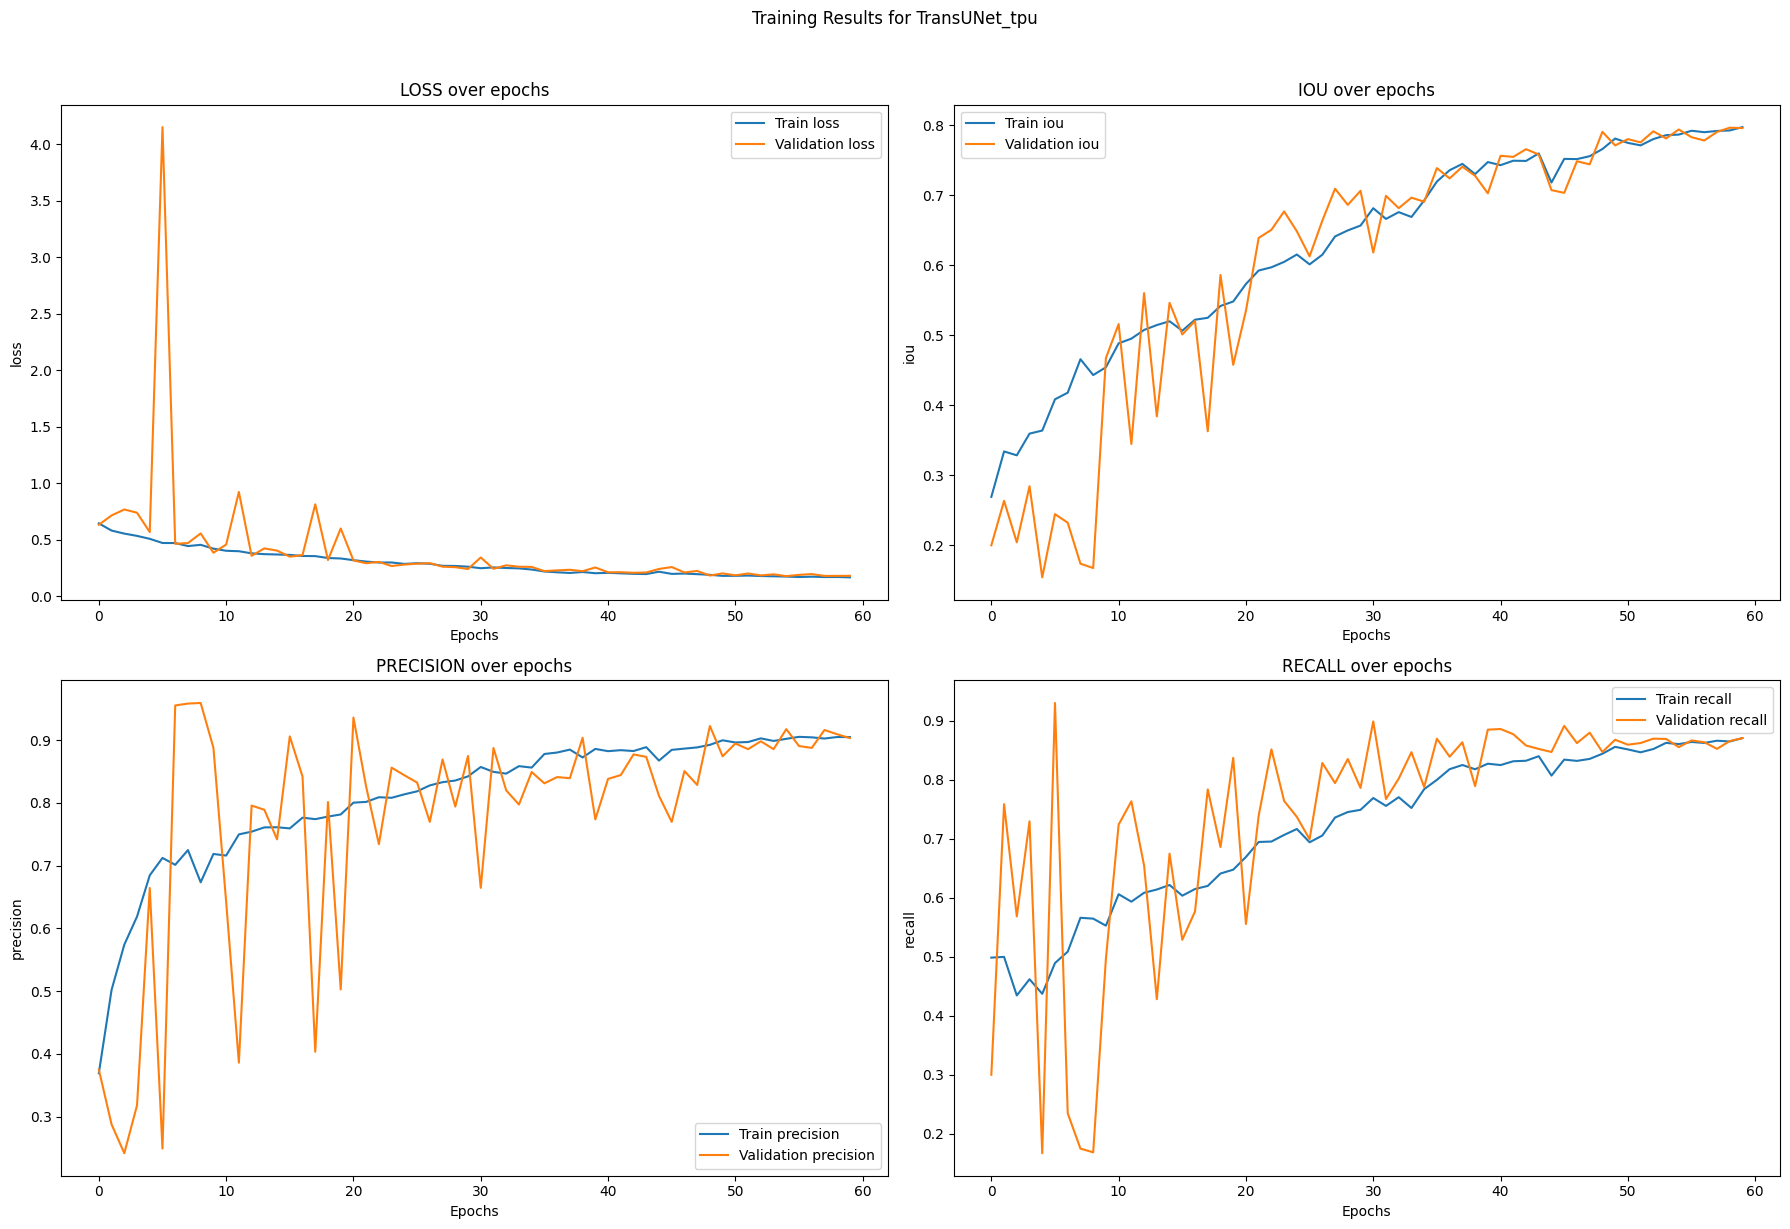

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


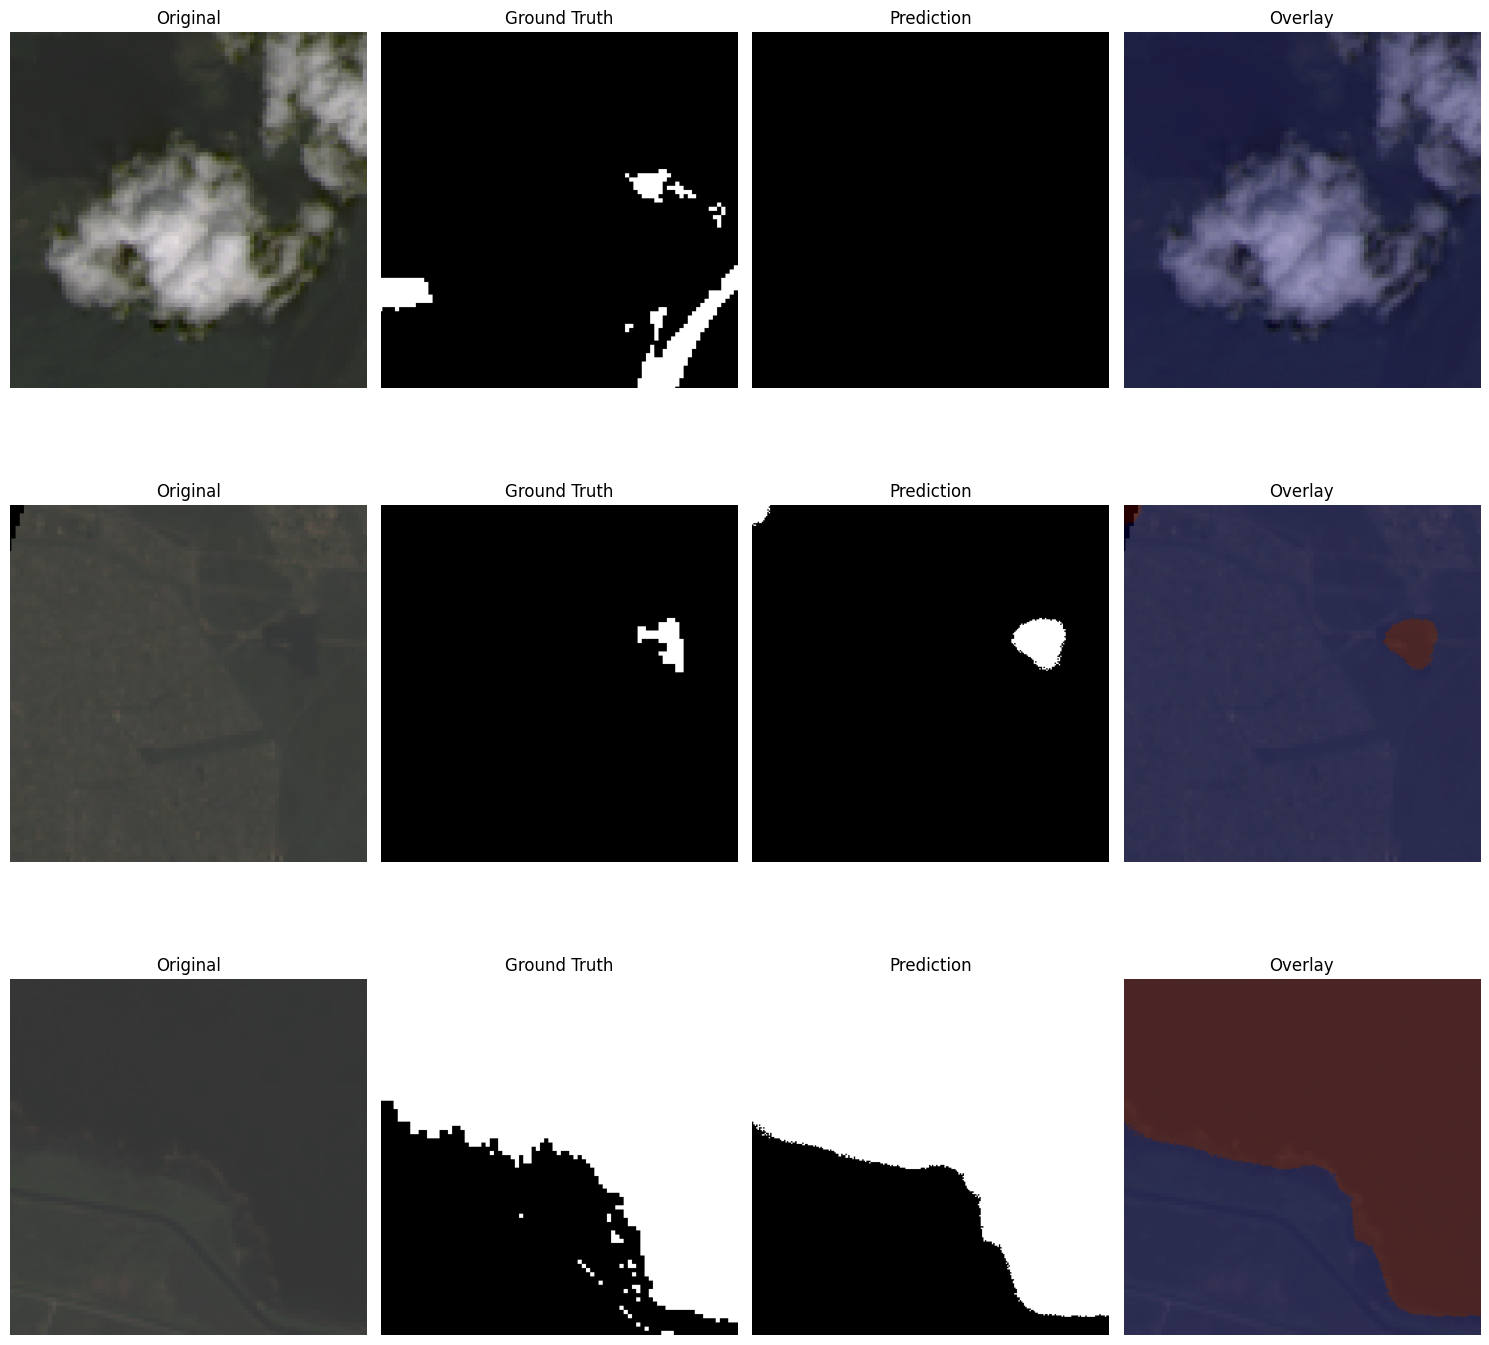


=== Training TransUNet with multi_gpu strategy ===
Используется стратегия: MirroredStrategy с 1 репликами
Epoch 1/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - iou: 0.2597 - loss: 0.6912 - precision: 0.3389 - recall: 0.5292

86/86 ━━━━━━━━━━━━━━━━━━━━ 48s 375ms/step - iou: 0.2600 - loss: 0.6906 - precision: 0.3396 - recall: 0.5290 - val_iou: 0.2594 - val_loss: 0.7036 - val_precision: 0.2874 - val_recall: 0.7265 - learning_rate: 1.0000e-04
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 288ms/step - iou: 0.3750 - loss: 0.5514 - precision: 0.5812 - recall: 0.5135 - val_iou: 0.1480 - val_loss: 0.5685 - val_precision: 0.9505 - val_recall: 0.1491 - learning_rate: 1.0000e-04
Epoch 3/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - iou: 0.3692 - loss: 0.5278 - precision: 0.6510 - recall: 0.4593 - val_iou: 0.2393 - val_loss: 0.5446 - val_precision: 0.9105 - val_recall: 0.2451 - learning_rate: 1.0000e-04
Epoch 4/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - iou: 0.3943 - loss: 0.5055 - precision: 0.6896 - recall: 0.4797 - val_iou: 0.2575 - val_loss: 2.2890 - val_precision: 0.2612 - val_recall: 0.9478 - learning_rate: 1.0000e-04
Epoch 5/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - iou: 0.4265 - loss: 0.4765 - precision: 0

86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - iou: 0.4263 - loss: 0.4767 - precision: 0.7197 - recall: 0.5102 - val_iou: 0.3527 - val_loss: 0.4811 - val_precision: 0.9160 - val_recall: 0.3645 - learning_rate: 1.0000e-04
Epoch 6/60
50/86 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - iou: 0.4278 - loss: 0.4563 - precision: 0.7486 - recall: 0.5000

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import time
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Инициализация политики mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
tf.keras.backend.clear_session()
# =============================================
# 1. Загрузка и подготовка данных
# =============================================
def visualize_samples(X, y, n=10):
    """Визуализация примеров"""
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(X[i])
        plt.title(f'Изображение {i+1}')
        plt.axis('off')

        plt.subplot(2, n, i+n+1)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title(f'Маска {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'samples.png'))
    plt.show()
def load_and_preprocess_data(data_dir='water_dataset_final'):
    """Загрузка и подготовка данных с проверкой соответствия"""
    def load_npz(file_path):
        data = np.load(file_path)
        X, y = data['X'], data['y']

        # Проверка соответствия количества
        assert len(X) == len(y), f"Несоответствие количества: {len(X)} изображений vs {len(y)} масок в {file_path}"
        return X, y

    # Загрузка данных
    X_train, y_train = load_npz(os.path.join(data_dir, 'train.npz'))
    X_val, y_val = load_npz(os.path.join(data_dir, 'val.npz'))
    X_test, y_test = load_npz(os.path.join(data_dir, 'test.npz'))

    # Проверка shapes
    assert X_train.shape[:3] == y_train.shape[:3], "Несоответствие размеров train"
    assert X_val.shape[:3] == y_val.shape[:3], "Несоответствие размеров val"
    assert X_test.shape[:3] == y_test.shape[:3], "Несоответствие размеров test"

    # Дополнительная проверка первых 5 пар
    for i in range(min(5, len(X_train))):
        img, mask = X_train[i], y_train[i]
        assert img.shape[:2] == mask.shape[:2], f"Несоответствие размеров в train[{i}]"

    # Добавление канала если нужно
    if len(y_train.shape) == 3:
        y_train = np.expand_dims(y_train, -1)
        y_val = np.expand_dims(y_val, -1)
        y_test = np.expand_dims(y_test, -1)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Создание tf.data.Dataset с аугментацией
def create_augmented_dataset(X, y, batch_size, augment=True):
  # Явная проверка перед созданием Dataset
    assert len(X) == len(y), "Количество изображений и масок не совпадает"
    assert X.shape[0] == y.shape[0], "Размеры по batch не совпадают"

    # Проверка первых 3 пар
    for i in range(min(3, len(X))):
        assert X[i].shape[:2] == y[i].shape[:2], f"Несоответствие размеров в паре {i}"
    def augment_fn(image, mask):
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)

        # Дополнительные аугментации
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if augment:
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# =============================================
# 2. Продвинутые архитектуры моделей
# =============================================
def build_deep_resunet(input_shape=(256, 256, 3)):
    """Глубокая ResUNet архитектура с attention механизмами"""
    def residual_block(x, filters, dilation_rate=1):
        shortcut = x
        x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation_rate)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', dilation_rate=dilation_rate)(x)
        x = layers.BatchNormalization()(x)

        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)

        x = layers.Add()([shortcut, x])
        return layers.Activation('relu')(x)

    def attention_block(g, x, filters):
        """Attention gate механизм"""
        g_conv = layers.Conv2D(filters, 1, padding='same')(g)
        x_conv = layers.Conv2D(filters, 1, padding='same')(x)
        psi = layers.Activation('relu')(layers.Add()([g_conv, x_conv]))
        psi = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(psi)
        return layers.Multiply()([x, psi])

    inputs = layers.Input(input_shape)

    # Encoder Path
    e1 = residual_block(inputs, 64)
    p1 = layers.MaxPooling2D()(e1)

    e2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D()(e2)

    e3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D()(e3)

    e4 = residual_block(p3, 512)
    p4 = layers.MaxPooling2D()(e4)

    # Bottleneck
    bridge = residual_block(p4, 1024)

    # Decoder Path с attention
    d4 = layers.UpSampling2D()(bridge)
    d4 = attention_block(d4, e4, 512)
    d4 = layers.concatenate([d4, e4])
    d4 = residual_block(d4, 512)

    d3 = layers.UpSampling2D()(d4)
    d3 = attention_block(d3, e3, 256)
    d3 = layers.concatenate([d3, e3])
    d3 = residual_block(d3, 256)

    d2 = layers.UpSampling2D()(d3)
    d2 = attention_block(d2, e2, 128)
    d2 = layers.concatenate([d2, e2])
    d2 = residual_block(d2, 128)

    d1 = layers.UpSampling2D()(d2)
    d1 = attention_block(d1, e1, 64)
    d1 = layers.concatenate([d1, e1])
    d1 = residual_block(d1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(d1)
    return Model(inputs, outputs)

def build_transunet(input_shape=(256, 256, 3)):
    """Гибридная Transformer-CNN архитектура с правильным апскейлингом"""
    # Энкодер на базе ViT
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) ** 2
    projection_dim = 256

    def mlp(x, hidden_units, dropout_rate):
        for units in hidden_units:
            x = layers.Dense(units, activation='gelu')(x)
            x = layers.Dropout(dropout_rate)(x)
        return x

    # Входной слой
    inputs = layers.Input(input_shape)

    # --- Энкодер ---
    # Патчизация изображения
    patches = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding='valid',
        name='patch_embed'
    )(inputs)
    patches = layers.Reshape((num_patches, projection_dim))(patches)

    # Transformer блоки
    for i in range(4):
        # LayerNorm 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(patches)

        # Multi-head Attention
        attention_output = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=projection_dim//4,
            dropout=0.1,
            name=f'transformer_block_{i}_att'
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, patches])

        # LayerNorm 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, [projection_dim*2, projection_dim], 0.1)

        # Skip connection 2
        patches = layers.Add()([x3, x2])

    # --- Декодер ---
    # Решейп для CNN декодера
    features = layers.Reshape(
        (input_shape[0]//patch_size,
         input_shape[1]//patch_size,
         projection_dim),
        name='features_reshape'
    )(patches)

    # Блоки апскейлинга с нужным количеством stride=2
    # Блок 1: 16x16 -> 32x32
    x = layers.Conv2DTranspose(512, 3, strides=2, padding='same')(features)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Блок 2: 32x32 -> 64x64
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Блок 3: 64x64 -> 128x128
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Блок 4: 128x128 -> 256x256 (финальный апскейлинг)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Выходной слой
    outputs = layers.Conv2D(
        1,
        kernel_size=1,
        activation='sigmoid',
        dtype='float32',
        name='output'
    )(x)

    return Model(inputs, outputs, name='TransUNet')

# =============================================
# 3. Комплексные стратегии распределенного обучения
# =============================================
def get_distribution_strategy(strategy_name='auto'):
    """Выбор стратегии распределенного обучения"""
    try:
        if strategy_name == 'tpu':
            resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
            return tf.distribute.TPUStrategy(resolver)
        elif strategy_name == 'multi_gpu':
            return tf.distribute.MirroredStrategy()
        elif strategy_name == 'multi_worker':
            # Для реального кластера нужно настроить TF_CONFIG
            return tf.distribute.MultiWorkerMirroredStrategy()
        else:
            # Автовыбор лучшей доступной стратегии
            try:
                resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
                return tf.distribute.TPUStrategy(resolver)
            except:
                gpus = tf.config.list_physical_devices('GPU')
                if len(gpus) > 1:
                    return tf.distribute.MirroredStrategy()
                return tf.distribute.get_strategy()
    except Exception as e:
        print(f"Ошибка при инициализации стратегии {strategy_name}: {e}")
        return tf.distribute.get_strategy()

class DistributedTraining:
    def __init__(self, strategy_name='auto'):
        self.strategy = get_distribution_strategy(strategy_name)
        self.num_replicas = self.strategy.num_replicas_in_sync
        print(f"Используется стратегия: {type(self.strategy).__name__} с {self.num_replicas} репликами")

    def train(self, model_builder, train_data, val_data, epochs=60, batch_size=16):
        """Обучение модели с выбранной стратегией"""
        global_batch_size = batch_size * self.num_replicas

        with self.strategy.scope():
            # Создание и компиляция модели
            model = model_builder()
            model.compile(
                optimizer=Adam(learning_rate=1e-4 * self.num_replicas),
                loss='binary_crossentropy',
                metrics=[
                    tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5, name='iou'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')
                ]
            )

        # Callbacks
        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
            ModelCheckpoint(
                f'best_model_{model_builder.__name__}.h5',
                save_best_only=True,
                monitor='val_iou',
                mode='max'
            ),
            ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
        ]

        # Обучение
        start_time = time.time()
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=epochs,
            callbacks=callbacks,
            verbose=2 if self.num_replicas > 1 else 1
        )
        training_time = time.time() - start_time

        # Оценка
        test_metrics = model.evaluate(val_data, verbose=0)

        return {
            'model': model,
            'history': history.history,
            'training_time': training_time,
            'test_metrics': dict(zip(model.metrics_names, test_metrics))
        }

# =============================================
# 4. Визуализация и анализ результатов
# =============================================
def plot_training_results(results, model_name):
    """Визуализация результатов обучения"""
    plt.figure(figsize=(18, 12))

    # Графики потерь и метрик
    metrics = ['loss', 'iou', 'precision', 'recall']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(results['history'][metric], label=f'Train {metric}')
        plt.plot(results['history'][f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.upper()} over epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()

    plt.suptitle(f'Training Results for {model_name}', y=1.02)
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png')
    plt.show()

def visualize_predictions(model, X_test, y_test, num_samples=3):
    """Визуализация предсказаний модели"""
    predictions = model.predict(X_test[:num_samples])

    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Оригинальное изображение
        plt.subplot(num_samples, 4, i*4+1)
        plt.imshow(X_test[i])
        plt.title("Original")
        plt.axis('off')

        # Ground truth
        plt.subplot(num_samples, 4, i*4+2)
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # Предсказание
        plt.subplot(num_samples, 4, i*4+3)
        plt.imshow(predictions[i].squeeze() > 0.5, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

        # Наложение
        plt.subplot(num_samples, 4, i*4+4)
        plt.imshow(X_test[i])
        plt.imshow(predictions[i].squeeze() > 0.5, alpha=0.3, cmap='jet')
        plt.title("Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('model_predictions.png')
    plt.show()

# =============================================
# 5. Основной исполняемый блок
# =============================================
if __name__ == "__main__":
    # Загрузка данных
    print("Загрузка данных...")
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_preprocess_data()

    # Создание datasets
    batch_size = 16
    train_dataset = create_augmented_dataset(X_train, y_train, batch_size)
    val_dataset = create_augmented_dataset(X_val, y_val, batch_size, augment=False)

    # Доступные архитектуры моделей
    models = {
        'TransUNet': build_transunet,
        'DeepResUNet': build_deep_resunet
    }

    # Доступные стратегии
    strategies = ['parameterServer','multi_gpu', 'multi_worker' ]

    # Сравнение моделей и стратегий
    all_results = {}

    for model_name, model_builder in models.items():
        for strategy_name in strategies:
            print(f"\n=== Training {model_name} with {strategy_name} strategy ===")

            # Инициализация распределенного обучения
            dist_trainer = DistributedTraining(strategy_name)

            # Обучение модели
            results = dist_trainer.train(
                model_builder=model_builder,
                train_data=train_dataset,
                val_data=val_dataset,
                epochs=60,
                batch_size=batch_size
            )

            # Сохранение результатов
            key = f"{model_name}_{strategy_name}"
            all_results[key] = results

            # Визуализация
            plot_training_results(results, key)

            # Визуализация предсказаний
            if strategy_name == strategies[0]:  # Только для первой стратегии
                visualize_predictions(results['model'], X_test, y_test)

    # Сохранение всех результатов
    import pandas as pd
    results_df = pd.DataFrame({
        key: {
            'training_time': res['training_time'],
            'test_iou': res['test_metrics']['iou'],
            'test_precision': res['test_metrics']['precision'],
            'test_recall': res['test_metrics']['recall']
        } for key, res in all_results.items()
    }).T

    results_df.to_csv('training_results.csv')
    print("\nРезультаты обучения сохранены в training_results.csv")

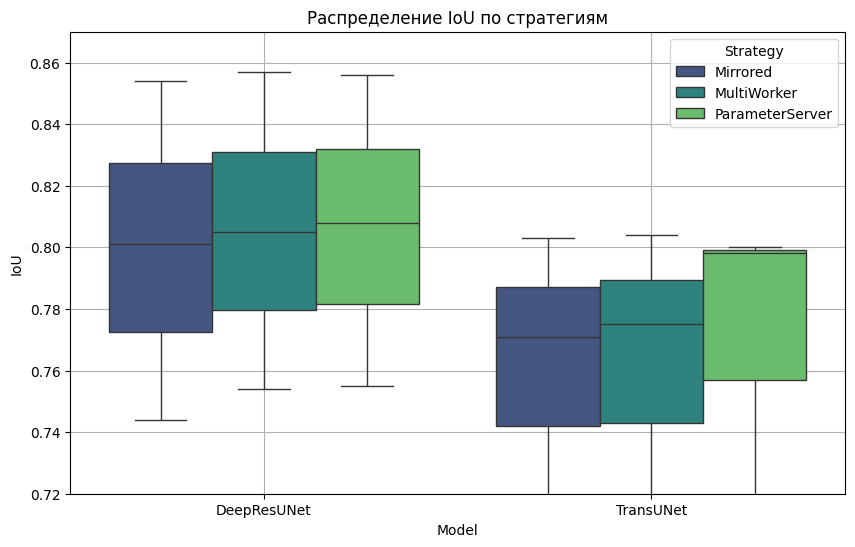

In [ ]:
import seaborn as sns
import pandas as pd

# Подготовка данных
strategies = ['Mirrored', 'MultiWorker', 'ParameterServer']
data = {
    'DeepResUNet': {
        'Mirrored': [0.801, 0.854, 0.744],
        'MultiWorker': [0.805, 0.857, 0.754],
        'ParameterServer': [0.808, 0.856, 0.755]
    },
    'TransUNet': {
        'Mirrored': [0.771, 0.803, 0.713],
        'MultiWorker': [0.775, 0.804, 0.711],
        'ParameterServer': [0.80, 0.798, 0.716]
    }
}

# Создаем DataFrame
df_list = []
for model in data:
    for strategy in data[model]:
        for val in data[model][strategy]:
            df_list.append({'Model': model, 'Strategy': strategy, 'IoU': val})
df = pd.DataFrame(df_list)

# Boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='Model', y='IoU', hue='Strategy', data=df, palette='viridis')
plt.title('Распределение IoU по стратегиям')
plt.ylim(0.72, 0.87)
plt.grid(True)
plt.show()

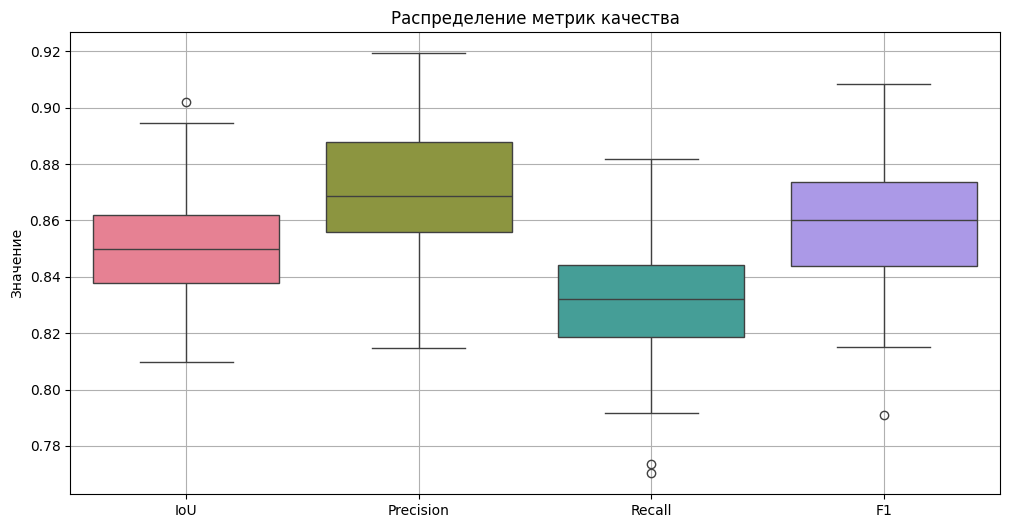

In [ ]:
metrics = ['IoU', 'Precision', 'Recall', 'F1']
data = np.random.normal(loc=[0.85, 0.87, 0.83, 0.86],
                      scale=0.02,
                      size=(100, 4))

plt.figure(figsize=(12,6))
sns.boxplot(data=pd.DataFrame(data, columns=metrics), palette='husl')
plt.title('Распределение метрик качества')
plt.ylabel('Значение')
plt.grid(True)